***
# <a id='toc1_'></a>[Data Collection: NCAA Men's March Madness](#toc0_)

This notebook serves as the foundation for the broader **NCAA Division I Men’s Basketball: Data Science / Machine Learning Project**. It focuses on two core objectives:

1) **Data Collection & Cleaning**: We consolidate, normalize, and engineer features from various NCAA datasets, covering:
- Regular season results
- Advanced team statistics (e.g., KenPom ratings)
- Historical performance trends

2) **Exploratory Data Analysis (EDA)**: Before moving into predictive modeling, we explore key questions that define the structure of college basketball:
- How team strength has evolved over time? 
- How scoring and tempo have shifted?
- How conference affiliation impacts team quality?

The goal is to build intuition around the underlying data and uncover meaningful patterns that can inform downstream analysis, modeling, and ultimately, tournament prediction strategies.
***

**Table of contents**<a id='toc0_'></a>    
- [Data Collection: NCAA Men's March Madness](#toc1_)    
    - [Imports & Global Settings](#toc1_1_1_)    
  - [Data Wrangling & Preprocessing](#toc1_2_)    
  - [Regular Season Results](#toc1_3_)    
  - [Observations: Top NCAA Teams by Wins and Losses (2003–2025)](#toc1_4_)    
  - [Restructure Data for Analysis](#toc1_5_)    
      - [Winning & Losing Dataframe Approach](#toc1_5_1_1_)    
    - [Create winning and losing dfs for the regular season results (`reg_results`)](#toc1_5_2_)    
  - [Game-level Statistics](#toc1_6_)    
    - [Distribution of Games Played per Team (2003–2025)](#toc1_6_1_)    
    - [Total Wins/Losses and Winning Percentage](#toc1_6_2_)    
  - [Massey Ordinals](#toc1_7_)    
    - [Missing KenPom Data for Select Schools (2008–2009)](#toc1_7_1_)    
  - [Aggregation Statistics](#toc1_8_)    
    - [Season-Level Aggregates](#toc1_8_1_)    
  - [EDA](#toc1_9_)    
    - [Scoring Margin Distribution](#toc1_9_1_)    
    - [Distribution of Average Scoring Margin](#toc1_9_2_)    
    - [Distribution of Scoring Over Time (2003–2025)](#toc1_9_3_)    
    - [Scoring and Tempo Trends Over Time (2003–2025)](#toc1_9_4_)    
    - [Team Performance and Playing Style](#toc1_9_5_)    
    - [Relationship Between Team Style and Winning Percentage](#toc1_9_6_)    
    - [Conferences](#toc1_9_7_)    
      - [Inter-Conference Disparities](#toc1_9_7_1_)    
      - [Key Takeaways](#toc1_9_7_2_)    
      - [Power vs. Non-Power Conferences](#toc1_9_7_3_)    
      - [KenPom Rankings: Power vs. Non-Power Conferences](#toc1_9_7_4_)    
  - [Advanced Metrics](#toc1_10_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
### <a id='toc1_1_1_'></a>[Imports & Global Settings](#toc0_)

In [481]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.cluster import KMeans

from Utils import *

# Filter warnings 
from warnings import filterwarnings
filterwarnings(action='ignore')

In [ ]:
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
jimmer = 32 # Jimmer Fredette for randomizaion
duke = 1181 # TeamID for Duke to use for reference / debugging

***
## <a id='toc1_2_'></a>[Data Wrangling & Preprocessing](#toc0_)

**1) Load Raw Data** 
- Get team information (team names, conferences, etc.)
- Import data (`reg_results`, `tourney_results`, etc.)


**2) Restructure Data for Analysis**  
- Convert regular season results into team-level format
- Ensure each row represents a single team's performance in a game

**3) Game-level Statistics**  
- Compute additional game-level statistics not included in original dataset (before aggregation)

**4) Aggregation**  
- Aggregate stats for total season, wins only, losses only (e.g., FG%, WFG%, and LFG% to see if stats vary materially)
- Compute opponent stats for same granularity

**5) Advanced Metrics**
- Compute additional advanced metrics
- Incorporate precomputed advanced metrics (e.g., KenPom)

***

In [483]:
# Load in Team-level Info
teams = pd.read_csv('./Data/Mteams.csv', dtype={'TeamID': str}).set_index('TeamID')['TeamName']
conferences = pd.read_csv('./Data/MTeamConferences.csv', dtype={'TeamID': str})
conf_names = pd.read_csv('./Data/Conferences.csv')

In [484]:
display(teams.head())
display(conferences.head())
display(conf_names.head())

TeamID
1101    Abilene Chr
1102      Air Force
1103          Akron
1104        Alabama
1105    Alabama A&M
Name: TeamName, dtype: object

,Season,TeamID,ConfAbbrev
0,1985,1102,wac
1,1985,1103,ovc
2,1985,1104,sec
3,1985,1106,swac
4,1985,1108,swac


,ConfAbbrev,Description
0,a_sun,Atlantic Sun Conference
1,a_ten,Atlantic 10 Conference
2,aac,American Athletic Conference
3,acc,Atlantic Coast Conference
4,aec,America East Conference


In [485]:
# Shapes of original data
print(teams.shape)
print(conferences.shape)
print(conf_names.shape)

# Check Nulls
print(teams.isna().sum().sum())
print(conferences.isna().sum().sum())
print(conf_names.isna().sum().sum())

# Check dupes
print(teams.duplicated().sum().sum())
print(conferences.duplicated().sum().sum())
print(conf_names.duplicated().sum().sum())

(380,)
(13388, 3)
(51, 2)
0
0
0
0
0
0


In [486]:
# Merge Team and conference info
conferences['TeamName'] = conferences['TeamID'].map(teams)
team_info = conferences.merge(conf_names, on='ConfAbbrev')
team_info['ConfAbbrev'] = team_info['ConfAbbrev'].str.upper()

The large number of records in the `conferences` dataset is likely due to frequent conference realignments over time.

In recent years, several major college programs have switched conferences, primarily driven by financial incentives, competitive opportunities, and long-term stability. Below is a list of some recent, notable conference moves.

| Year | School Name                               | New Conference | Previous Conference |
|------|-------------------------------------------|----------------|---------------------|
| 2011 | University of Nebraska                    | Big Ten        | Big 12              |
| 2012 | Texas A&M University                      | SEC            | Big 12              |
| 2012 | University of Missouri                    | SEC            | Big 12              |
| 2013 | University of Pittsburgh                  | ACC            | Big East            |
| 2013 | Syracuse University                       | ACC            | Big East            |
| 2014 | University of Louisville                  | ACC            | American Athletic   |
| 2014 | University of Maryland                    | Big Ten        | ACC                 |
| 2024 | University of California, Los Angeles     | Big Ten        | Pac-12              |
| 2024 | University of Southern California         | Big Ten        | Pac-12              |
| 2024 | University of Oregon                      | Big Ten        | Pac-12              |
| 2024 | University of Washington                  | Big Ten        | Pac-12              |
| 2024 | University of Arizona                     | Big 12         | Pac-12              |
| 2024 | Arizona State University                  | Big 12         | Pac-12              |
| 2024 | University of Colorado                    | Big 12         | Pac-12              |
| 2024 | University of Utah                        | Big 12         | Pac-12              |
| 2024 | University of California, Berkeley        | ACC            | Pac-12              |
| 2024 | Stanford University                       | ACC            | Pac-12              |


The large exodus of teams from the `Pac-12` in 2024 was due to the conference's inability to secure a competitive media rights deal, while other conferences (Big Ten, SEC, Big 12) locked in lucrative TV contracts with networks like ESPN, Fox, and CBS.

In [487]:
# Example team and conference movement for Stanford
school = 'Stanford'
school_conferences = team_info[team_info['TeamName'] == school]['ConfAbbrev'].unique()
print(f"{school}: {school_conferences}")

Stanford: ['PAC_TEN' 'PAC_TWELVE' 'ACC']


In [488]:
display(team_info.head())
print(team_info.shape)
print(team_info.isna().sum().sum())

,Season,TeamID,ConfAbbrev,TeamName,Description
0,1985,1102,WAC,Air Force,Western Athletic Conference
1,1985,1103,OVC,Akron,Ohio Valley Conference
2,1985,1104,SEC,Alabama,Southeastern Conference
3,1985,1106,SWAC,Alabama St,Southwest Athletic Conference
4,1985,1108,SWAC,Alcorn St,Southwest Athletic Conference


(13388, 5)
0


In [489]:
# Reorder columns
team_info = team_info[['Season', 'TeamID', 'TeamName','ConfAbbrev','Description']]

# Extract range of team info
max_season = team_info['Season'].max()
min_season = team_info['Season'].min()

print(f"The dataset contains historical data for {team_info['Season'].nunique()} seasons ({min_season} - {max_season}).")
print(f"It includes information on {team_info['TeamID'].nunique()} unique teams across {team_info['ConfAbbrev'].nunique()} historical conferences.")

display(team_info.head())

The dataset contains historical data for 41 seasons (1985 - 2025).
It includes information on 380 unique teams across 51 historical conferences.


,Season,TeamID,TeamName,ConfAbbrev,Description
0,1985,1102,Air Force,WAC,Western Athletic Conference
1,1985,1103,Akron,OVC,Ohio Valley Conference
2,1985,1104,Alabama,SEC,Southeastern Conference
3,1985,1106,Alabama St,SWAC,Southwest Athletic Conference
4,1985,1108,Alcorn St,SWAC,Southwest Athletic Conference


***
## <a id='toc1_3_'></a>[Regular Season Results](#toc0_)

**Load Historical Regular Season Data**

The below dataset represents detailed, game-level box scores for the **regular season** where:
- `WTeamID` and `LTeamID` represent the teams that won and lost each game, respectively.
- Team statistics are prefixed with **"W"** for the winning team and **"L"** for the losing team.
***

In [490]:
# Historical Regular Season Results
reg_results = pd.read_csv('./Data/MRegularSeasonDetailedResults.csv', dtype={
        'WTeamID': str,
        'LTeamID': str
        })

In [491]:
# Extract range / timespan of regular season data
max_season = reg_results['Season'].max()
min_season = reg_results['Season'].min()
print(f"The Regular Season dataset contains historical data for {reg_results['Season'].nunique()} seasons ({max_season} - {min_season}).")

print(f"Shape of Regular Season Results: {reg_results.shape}")
display(reg_results.head())

The Regular Season dataset contains historical data for 23 seasons (2025 - 2003).
Shape of Regular Season Results: (118882, 34)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,56,1457,50,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,77,1208,71,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [492]:
# Add Team names to season results
reg_results['WTeamName'] = reg_results['WTeamID'].map(teams)
reg_results['LTeamName'] = reg_results['LTeamID'].map(teams)

# Add Losing Location to season results and tournament results (Opposite of WLoc)
reg_results['LLoc'] = reg_results['WLoc'].map({'H': 'A', 'A': 'H', 'N': 'N'})

In [493]:
# Quickly reorder columns
reorder = ['Season', 'DayNum', 'WTeamID', 'WTeamName', 'LTeamID', 'LTeamName', 'WScore', 'LScore', 'WLoc', 'LLoc',  'NumOT']
reg_results = reg_results[reorder + [col for col in reg_results.columns if col not in reorder]]

display(reg_results.head())

,Season,DayNum,WTeamID,WTeamName,LTeamID,LTeamName,WScore,LScore,WLoc,LLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,Alabama,1328,Oklahoma,68,62,N,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,Memphis,1393,Syracuse,70,63,N,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,Marquette,1437,Villanova,73,61,N,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,N Illinois,1457,Winthrop,56,50,N,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,Texas,1208,Georgia,77,71,N,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


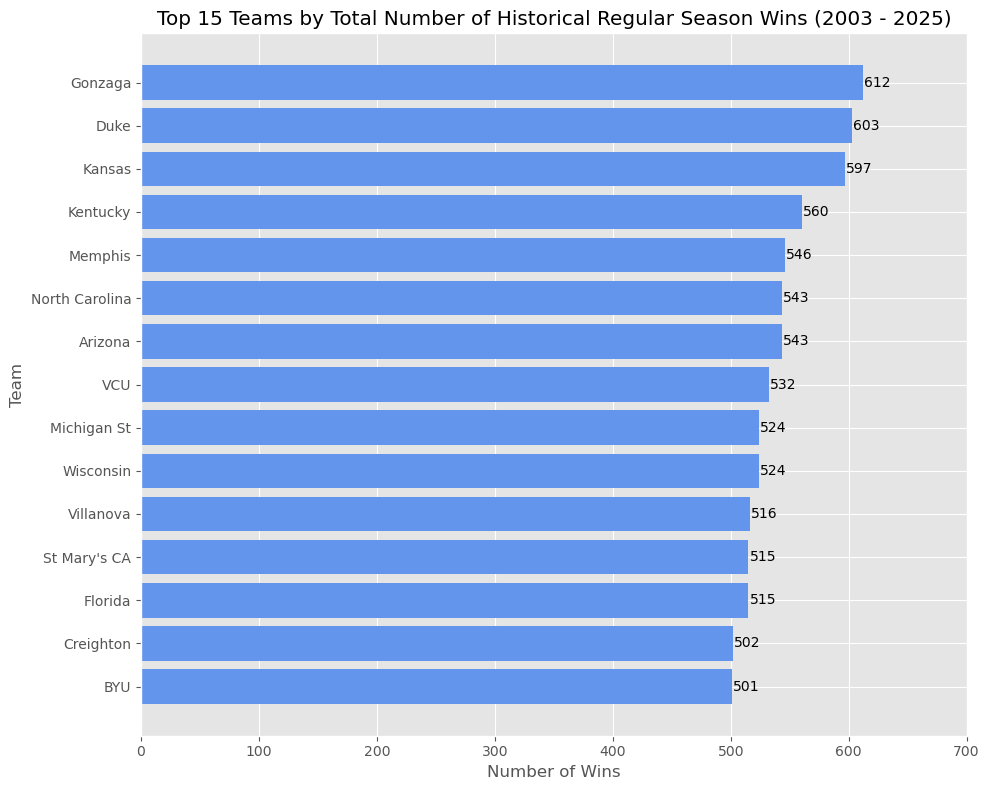

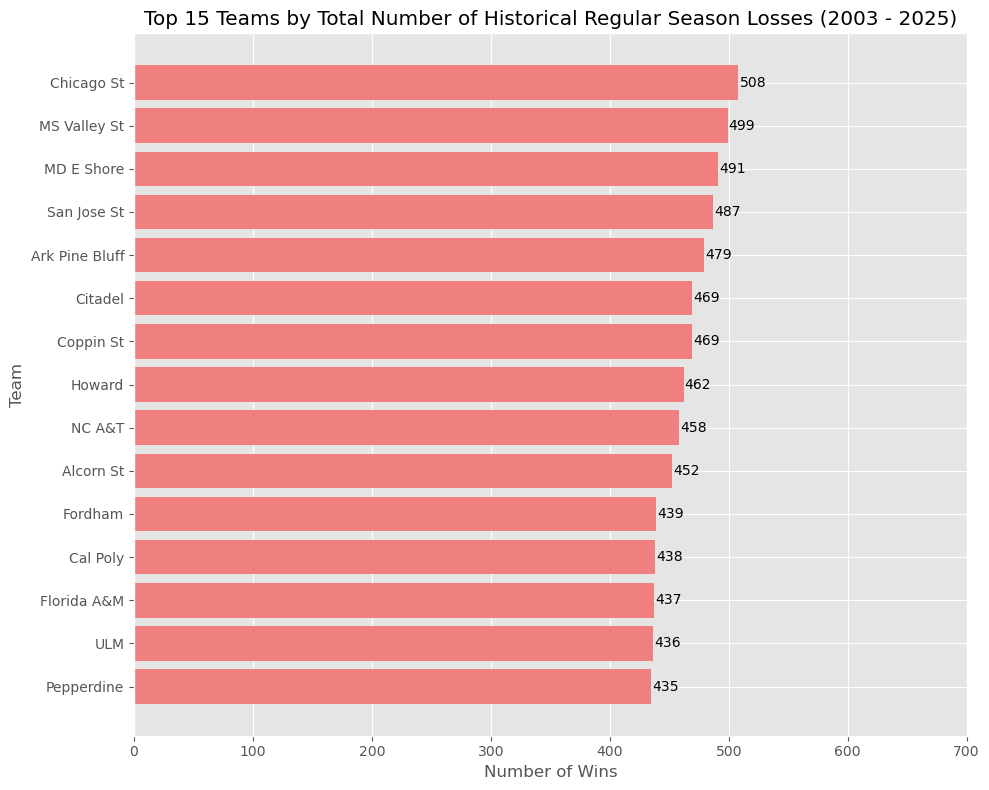

In [494]:
# Plot top n_teams by total number of wins and total number of losses since 2003
n = 15
figsize = (10,8)

# Extract top n wins and losses from regular season results df
num_wins_by_team = reg_results['WTeamName'].value_counts().head(n)
num_losses_by_team = reg_results['LTeamName'].value_counts().head(n)

# Plot top n team by total number of wins
fig, ax = plt.subplots(figsize=figsize)
ax.barh(num_wins_by_team.index, num_wins_by_team.values, color='cornflowerblue')
ax.set_title(f"Top {n} Teams by Total Number of Historical Regular Season Wins (2003 - 2025)")
ax.set_xlabel("Number of Wins")
ax.set_ylabel("Team")
ax.set_xlim(0, 700)
ax.invert_yaxis() # Sort descending

# Add labels
for i, v in enumerate(num_wins_by_team.values):
    ax.text(v + 1, i, str(v), va='center')

plt.tight_layout()
plt.show()

# Plot top n team by total number of losses
fig, ax = plt.subplots(figsize=figsize)
ax.barh(num_losses_by_team.index, num_losses_by_team.values, color='lightcoral')
ax.set_title(f"Top {n} Teams by Total Number of Historical Regular Season Losses (2003 - 2025)")
ax.set_xlabel("Number of Wins")
ax.set_ylabel("Team")
ax.set_xlim(0, 700)
ax.invert_yaxis() # Sort descending

# Add labels
for i, v in enumerate(num_losses_by_team.values):
    ax.text(v + 1, i, str(v), va='center')

plt.tight_layout()
plt.show()

***
## <a id='toc1_4_'></a>[Observations: Top NCAA Teams by Wins and Losses (2003–2025)](#toc0_)
Here we have some powerhouses like `Gonzaga`, `Duke`, `Kansas`, and `Kentucky` leading the way in total regular season wins. These programs are often referred to as **"blue bloods"**—a term used to describe schools with a long history of basketball success, strong recruiting pipelines, and significant national recognition. Other perennial contenders like `North Carolina`, `Arizona`, `Michigan State`, and `Villanova` also appear near the top, reflecting their consistent performance over the past two decades.

Notably, teams like `VCU`, `St Mary's (CA)`, and `Creighton` make the top 15 as well. While not traditionally considered blue bloods, these programs have consistently outperformed within their respective conferences and carved out a reputation for high-level play and strong regular season records.

On the losses side, we see a very different picture. The top 15 teams with the most regular season losses are primarily mid- to low-major programs like `Chicago State`, `Mississippi Valley State`, and `Maryland Eastern Shore`. hese schools often face structural disadvantages—fewer resources, lower recruiting visibility, or tougher non-conference schedules—which contribute to high regular season loss totals over time.

Overall, the contrast between the most winning and most losing programs highlights the competitive and resource disparities across Division I men's basketball.
***

## <a id='toc1_5_'></a>[Restructure Data for Analysis](#toc0_)

Currently, each row in the dataset represents a single game with two teams:
- Winning Team (`WTeamID`), with stats prefixed by `"W"` (e.g., `WFGM`, `WFGA`, `WTO`)
- Losing Team (`LTeamID`), with stats prefixed by `"L"` (e.g., `LFGM`, `LFGA`, `LTO`)

This structure makes it difficult to analyze teams independently because:
- A team's stats are split across two columns—sometimes under `"W"` and sometimes under `"L"`
- To compute season-level stats for a team, we would need to pull its games from both `WTeamID` and `LTeamID` and merge them
- There is no single `TeamID` column that consolidates all of a team's stats, making it impossible to group by `TeamID` alone

***

#### <a id='toc1_5_1_1_'></a>[Winning & Losing Dataframe Approach](#toc0_)
To fix this, separate **'winning'** and **'losing'** dataframes are created for the regular season results (`reg_results`).

- To create the 'winning' df, the **winning team** (`WTeamID`) is updated to `TeamID` and the losing team's stats are assigned as opponent stats (`OppFGM`, `OppFGA`, etc.)
- To create the 'losing df, the **losing team** (`LTeamID`) is updated to `TeamID` and the winning team's stats are assigned as opponent stats (`OppFGM`, `OppFGA`, etc.)
- The "W" and "L" prefixes are removed from both datasets to ensure that every row shares the same stat names (`FGM`, `FGA`, `TO`, `OppFGM` etc.)
- The dataframes are then merged into a **combined dataframe** where each row represents an individual team's game performance their opponent's statistics (regardless of W or L)

This transformation allows us to easily compute per-game, per-season, and opponent stats, which will be highly beneficial for feature engineering and modeling.
***

### <a id='toc1_5_2_'></a>[Create winning and losing dfs for the regular season results (`reg_results`)](#toc0_)

In [495]:
reg_results.head()

,Season,DayNum,WTeamID,WTeamName,LTeamID,LTeamName,WScore,LScore,WLoc,LLoc,NumOT,WFGM,WFGA,WFGM3,WFGA3,WFTM,WFTA,WOR,WDR,WAst,WTO,WStl,WBlk,WPF,LFGM,LFGA,LFGM3,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,Alabama,1328,Oklahoma,68,62,N,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,Memphis,1393,Syracuse,70,63,N,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,Marquette,1437,Villanova,73,61,N,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23
3,2003,11,1296,N Illinois,1457,Winthrop,56,50,N,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23
4,2003,11,1400,Texas,1208,Georgia,77,71,N,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14


In [496]:
non_WL_cols = [col for col in reg_results.columns if col[0] != 'W' and col[0] != 'L']
print(f"Game-level information columns (not winning or losing specific features): {non_WL_cols}")

Game-level information columns (not winning or losing specific features): ['Season', 'DayNum', 'NumOT']


In [497]:
def restructure_data(df):
    """
    Restructures game-level DataFrame such that each row represents a team's perspective
    in a single game, rather than a single game with a winner and loser.

    The function transforms each row into two rows:
    - One from the winner's perspective (with Win = 1 and GameResult = 'W')
    - One from the loser's perspective (with Win = 0 and GameResult = 'L')

    It also renames columns so that opponent information is labeled consistently
    with an 'Opp' prefix.

    Parameters:
        df (pd.DataFrame): Original game-level DataFrame where each row contains both
                           winning and losing team stats, with columns prefixed by 'W' and 'L'.

    Returns:
        pd.DataFrame: Restructured DataFrame with one row per team per game,
                      including Win, GameResult, and opponent stats.
    """
    df_copy = df.copy()
    
    # Make losing columns Opponent columns and remove prefix
    winning = df_copy.rename(columns=lambda x: f"Opp{x[1:]}" if x.startswith("L") else x)
    winning = winning.rename(columns=lambda x: x[1:] if x.startswith("W") else x)

    # Assign GameResult and Win columns
    winning["GameResult"] = 'W'
    winning["Win"] = 1

    # Make winning columns Opponent columns and remove prefix
    lossing = df_copy.rename(columns=lambda x: f"Opp{x[1:]}" if x.startswith("W") else x)
    lossing = lossing.rename(columns=lambda x: x[1:] if x.startswith("L") else x)

    # Assign GameResult and Win columns
    lossing["GameResult"] = 'L'
    lossing["Win"] = 0

    combined_df = pd.concat([winning, lossing], ignore_index=True)

    return combined_df

In [498]:
reg_combined_df = restructure_data(reg_results)

# There are 2 records for each game in the reg_combined_df, so the number of rows in the combined dataframe should be exactly double the original dataframe
assert len(reg_combined_df) == 2 * len(reg_results)

print(f"Missing Values: {reg_combined_df.isna().sum().sum()}")
print(f"Duplicate Values: {reg_combined_df.duplicated().sum().sum()}")
print(f"Shape:{reg_combined_df.shape}")
display(reg_combined_df)

Missing Values: 0
Duplicate Values: 0
Shape:(237764, 39)


,Season,DayNum,TeamID,TeamName,OppTeamID,OppTeamName,Score,OppScore,Loc,OppLoc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,OppFGM,OppFGA,OppFGM3,OppFGA3,OppFTM,OppFTA,OppOR,OppDR,OppAst,OppTO,OppStl,OppBlk,OppPF,GameResult,Win
0,2003,10,1104,Alabama,1328,Oklahoma,68,62,N,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,W,1
1,2003,10,1272,Memphis,1393,Syracuse,70,63,N,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,W,1
2,2003,11,1266,Marquette,1437,Villanova,73,61,N,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,W,1
3,2003,11,1296,N Illinois,1457,Winthrop,56,50,N,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,W,1
4,2003,11,1400,Texas,1208,Georgia,77,71,N,N,0,30,61,6,14,11,13,17,22,12,14,4,4,20,24,62,6,16,17,27,21,15,12,10,7,1,14,W,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237759,2025,132,1397,Tennessee,1196,Florida,77,86,N,N,0,22,49,8,26,25,32,5,20,15,9,7,5,21,26,61,9,27,25,28,15,24,11,8,6,1,25,L,0
237760,2025,132,1412,UAB,1272,Memphis,72,84,N,N,0,24,69,7,27,17,23,21,23,10,15,5,4,21,32,68,6,13,14,23,18,27,13,12,10,7,18,L,0
237761,2025,132,1458,Wisconsin,1276,Michigan,53,59,N,N,0,15,68,7,39,16,18,15,31,8,6,3,2,14,19,59,9,33,12,13,6,34,14,8,3,2,16,L,0
237762,2025,132,1206,George Mason,1433,VCU,63,68,N,N,0,19,56,9,21,16,19,14,19,13,11,11,3,22,19,47,8,25,22,27,11,25,10,16,7,9,20,L,0


***
## <a id='toc1_6_'></a>[Game-level Statistics](#toc0_)

- Create addtional game-level detail for more granularity and feature engineering opportunities
- Game-level information is added before any season-level aggregation is performed 
***

In [499]:
stat_dict = {
        'FG_Percentage': ('FGM', 'FGA'),
        'FG3_Percentage': ('FGM3', 'FGA3'),
        'FT_Percentage': ('FTM', 'FTA'),
        'Ast_TO_Ratio': ('Ast', 'TO')
    }


diff_stats = [
    'Score','FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA',
    'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF',

    # Advanced stats - Can add more diff_stats here as we consider additional advanced game-level stats
    'Poss', 'OffEff', 'DefEff'
]

In [500]:
def compute_game_features(df):
    """
    Computes per-game efficiency stats, possession-based metrics, difference features,
    and inverse opponent features to support modeling.
    """

    # Efficiency Stats (FG%, 3P%, FT%, Ast/TO)
    for new_col, (num, den) in stat_dict.items():
        df = create_percentage_col(df, num, den, new_col)
    for new_col, (num, den) in stat_dict.items():
        df = create_percentage_col(df, f"Opp{num}", f"Opp{den}", f"Opp{new_col}")

    # Possessions
    df["Poss"] = df["FGA"] - df["OR"] + df["TO"] + (0.475 * df["FTA"])
    df["OppPoss"] = df["OppFGA"] - df["OppOR"] + df["OppTO"] + (0.475 * df["OppFTA"])

    # Efficiency Ratings
    df["OffEff"] = df["Score"] / df["Poss"]
    df["DefEff"] = df["OppScore"] / df["OppPoss"]
    df["OppOffEff"] = df["DefEff"]
    df["OppDefEff"] = df["OffEff"]

    # Difference-Based Features
    for stat in diff_stats:
        df = create_difference_col(df, stat, f"Opp{stat}", f"{stat}_Diff")

    diff_cols = [col for col in reg_combined_df.columns if col.endswith('_Diff')]
    
    # Percentage-Based Differences
    for col in diff_cols:
        opp_col = col.replace("_Diff", "")
        new_col = f"{col}_Pct"
        df = create_percentage_col(df, col, f"Opp{opp_col}", new_col)

    # Opponent Difference Columns as Negatives
    opp_diff_dict = {
        f"{col}_Opp": -df[col]
        for col in df.columns
        if (col.endswith("_Diff") or col.endswith("_Diff_Pct")) and f"{col}_Opp" not in df.columns
    }

    # Concatenate new opponent diff columns
    df = pd.concat([df, pd.DataFrame(opp_diff_dict, index=df.index)], axis=1)

    return df

In [501]:
reg_combined_df = compute_game_features(reg_combined_df)

In [502]:
print('Regular Season Combined DataFrame:')
print(f"Shape: {reg_combined_df.shape}")
print(f"Missing values: {reg_combined_df.isna().sum().sum()}")
display(reg_combined_df.head())

Regular Season Combined DataFrame:
Shape: (237764, 121)
Missing values: 0


,Season,DayNum,TeamID,TeamName,OppTeamID,OppTeamName,Score,OppScore,Loc,OppLoc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,OppFGM,OppFGA,OppFGM3,OppFGA3,OppFTM,OppFTA,OppOR,OppDR,OppAst,OppTO,OppStl,OppBlk,OppPF,GameResult,Win,FG_Percentage,FG3_Percentage,FT_Percentage,Ast_TO_Ratio,OppFG_Percentage,OppFG3_Percentage,OppFT_Percentage,OppAst_TO_Ratio,Poss,OppPoss,OffEff,DefEff,OppOffEff,OppDefEff,Score_Diff,FGM_Diff,FGA_Diff,FGM3_Diff,FGA3_Diff,FTM_Diff,FTA_Diff,OR_Diff,DR_Diff,Ast_Diff,TO_Diff,Stl_Diff,Blk_Diff,PF_Diff,Poss_Diff,OffEff_Diff,DefEff_Diff,Score_Diff_Pct,FGM_Diff_Pct,FGA_Diff_Pct,FGM3_Diff_Pct,FGA3_Diff_Pct,FTM_Diff_Pct,FTA_Diff_Pct,OR_Diff_Pct,DR_Diff_Pct,Ast_Diff_Pct,TO_Diff_Pct,Stl_Diff_Pct,Blk_Diff_Pct,PF_Diff_Pct,Poss_Diff_Pct,OffEff_Diff_Pct,DefEff_Diff_Pct,Score_Diff_Opp,FGM_Diff_Opp,FGA_Diff_Opp,FGM3_Diff_Opp,FGA3_Diff_Opp,FTM_Diff_Opp,FTA_Diff_Opp,OR_Diff_Opp,DR_Diff_Opp,Ast_Diff_Opp,TO_Diff_Opp,Stl_Diff_Opp,Blk_Diff_Opp,PF_Diff_Opp,Poss_Diff_Opp,OffEff_Diff_Opp,DefEff_Diff_Opp,Score_Diff_Pct_Opp,FGM_Diff_Pct_Opp,FGA_Diff_Pct_Opp,FGM3_Diff_Pct_Opp,FGA3_Diff_Pct_Opp,FTM_Diff_Pct_Opp,FTA_Diff_Pct_Opp,OR_Diff_Pct_Opp,DR_Diff_Pct_Opp,Ast_Diff_Pct_Opp,TO_Diff_Pct_Opp,Stl_Diff_Pct_Opp,Blk_Diff_Pct_Opp,PF_Diff_Pct_Opp,Poss_Diff_Pct_Opp,OffEff_Diff_Pct_Opp,DefEff_Diff_Pct_Opp
0,2003,10,1104,Alabama,1328,Oklahoma,68,62,N,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,W,1,0.465517,0.214286,0.611111,0.565217,0.415094,0.200000,0.727273,0.444444,75.550,71.450,0.900066,0.867740,0.867740,0.900066,6,5,5,1,4,-5,-4,4,2,5,5,-2,-1,2,4.100,0.032327,-0.032327,0.096774,0.227273,0.094340,0.500000,0.400000,-0.312500,-0.181818,0.400000,0.090909,0.625000,0.277778,-0.222222,-0.500000,0.100000,0.057383,0.037254,-0.035916,-6,-5,-5,-1,-4,5,4,-4,-2,-5,-5,2,1,-2,-4.100,-0.032327,0.032327,-0.096774,-0.227273,-0.094340,-0.500000,-0.400000,0.312500,0.181818,-0.400000,-0.090909,-0.625000,-0.277778,0.222222,0.500000,-0.100000,-0.057383,-0.037254,0.035916
1,2003,10,1272,Memphis,1393,Syracuse,70,63,N,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,W,1,0.419355,0.400000,0.526316,1.230769,0.358209,0.250000,0.450000,0.583333,69.025,68.500,1.014125,0.919708,0.919708,1.014125,7,2,-5,2,-4,1,-1,-5,3,9,1,-4,-2,2,0.525,0.094417,-0.094417,0.111111,0.083333,-0.074627,0.333333,-0.166667,0.111111,-0.050000,-0.250000,0.120000,1.285714,0.083333,-0.500000,-0.333333,0.125000,0.007664,0.102660,-0.093102,-7,-2,5,-2,4,-1,1,5,-3,-9,-1,4,2,-2,-0.525,-0.094417,0.094417,-0.111111,-0.083333,0.074627,-0.333333,0.166667,-0.111111,0.050000,0.250000,-0.120000,-1.285714,-0.083333,0.500000,0.333333,-0.125000,-0.007664,-0.102660,0.093102
2,2003,11,1266,Marquette,1437,Villanova,73,61,N,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,W,1,0.413793,0.444444,0.586207,1.500000,0.301370,0.115385,0.608696,0.750000,64.775,64.925,1.126978,0.939546,0.939546,1.126978,12,2,-15,5,-8,3,6,-14,4,6,-2,3,-3,2,-0.150,0.187432,-0.187432,0.196721,0.090909,-0.205479,1.666667,-0.307692,0.214286,0.260870,-0.451613,0.181818,0.666667,-0.166667,1.500000,-0.600000,0.086957,-0.002310,0.199493,-0.166314,-12,-2,15,-5,8,-3,-6,14,-4,-6,2,-3,3,-2,0.150,-0.187432,0.187432,-0.196721,-0.090909,0.205479,-1.666667,0.307692,-0.214286,-0.260870,0.451613,-0.181818,-0.666667,0.166667,-1.500000,0.600000,-0.086957,0.002310,-0.199493,0.166314
3,2003,11,1296,N Illinois,1457,Winthrop,56,50,N,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,W,1,0.473684,0.333333,0.548387,0.916667,0.367347,0.272727,0.533333,0.473684,58.725,58.125,0.953597,0.860215,0.860215,0.953597,6,0,-11,-3,-13,9,16,-11,-1,2,-7,10,-1,-5,0.600,0.093382,-0.093382,0.120000,0.000000,-0.224490,-0.500000,-0.590909,1.125000,1.066667,-0.647059,-0.050000,0.222222,-0.368421,2.500000,-0.333333,-0.217391,0.010323,0.108557,-0.097926,-6,0,11,3,13,-9,-16,11,1,-2,7,-10,1,5,-0.600,-0.093382,0.093382,-0.120000,-0.000000,0.224490,0.500000,0.590909,-1.125000,-1.0

In [503]:
team_win_pct = (
    reg_combined_df
    .groupby('TeamName')['Win']
    .agg(['count', 'sum'])  # 'count' = total games, 'sum' = total wins
    .rename(columns={'count': 'GamesPlayed', 'sum': 'Wins'})
)

team_win_pct['WinningPercentage'] = team_win_pct['Wins'] / team_win_pct['GamesPlayed']
team_win_pct = team_win_pct.sort_values('WinningPercentage', ascending=False)

In [504]:
# Take a look at highest and lowest winning %s
print(team_win_pct.shape)
display(team_win_pct.head())
display(team_win_pct.tail())

(371, 3)


,GamesPlayed,Wins,WinningPercentage
TeamName,,,
Gonzaga,722,612,0.847645
Duke,747,603,0.807229
Kansas,741,597,0.805668
Kentucky,742,560,0.754717
Memphis,742,546,0.735849


,GamesPlayed,Wins,WinningPercentage
TeamName,,,
W Salem St,107,26,0.242991
MD E Shore,640,149,0.232813
Chicago St,644,136,0.211180
Morris Brown,24,4,0.166667
West Georgia,30,5,0.166667


A few teams in the dataset have played significantly fewer games compared to most Division I programs during this time. For example, `Morris Brown` (24 games) and `West Georgia` (30 games) appear in the data but have limited representation, likely due to brief stints at the Division I level, transitional periods, or inclusion from historical data sources that captured occasional appearances.

These teams also show very low winning percentages, but with such small sample sizes, their records aren’t directly comparable to long-standing programs like `Gonzaga`, `Duke`, or `Kansas`. When analyzing win percentages, it’s important to consider a minimum games played threshold to avoid skewed interpretations from teams with limited data.

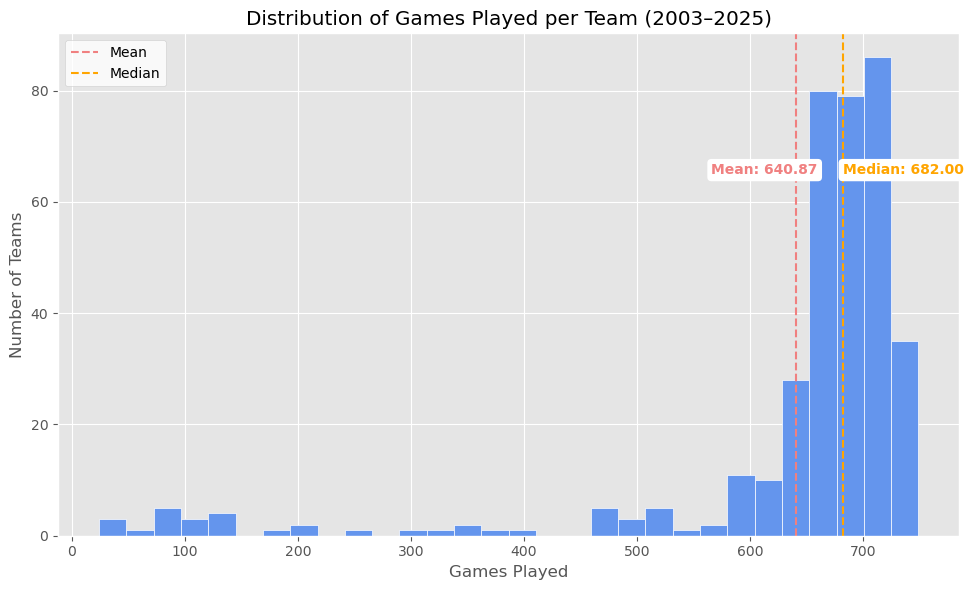

In [505]:
# Plot distribution of number of games played by team
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(team_win_pct['GamesPlayed'], bins=30, color='cornflowerblue', edgecolor='white')

ax.set_title("Distribution of Games Played per Team (2003–2025)")
ax.set_xlabel("Games Played")
ax.set_ylabel("Number of Teams")

# Add mean and Meidan lines
mean_games = team_win_pct['GamesPlayed'].mean()
median_games = team_win_pct['GamesPlayed'].median()

ax.axvline(mean_games, color='lightcoral', linestyle='dashed', linewidth=1.5, label='Mean')
ax.axvline(median_games, color='orange', linestyle='dashed', linewidth=1.5, label='Median')

# Add mean & median data labels
ax.text(mean_games - 75, 65, f"Mean: {mean_games:.2f}",
        color='lightcoral', fontsize=10, fontweight='bold',
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

ax.text(median_games, 65, f"Median: {median_games:.2f}",
        color='orange', fontsize=10, fontweight='bold',
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

legend = ax.legend()
legend.get_frame().set_facecolor('white')

plt.tight_layout()
plt.show()

In [506]:
pd.DataFrame(team_win_pct['GamesPlayed'].describe())

,GamesPlayed
count,371.000000
mean,640.873315
std,142.076445
min,24.000000
25%,654.500000
50%,682.000000
75%,708.500000
max,749.000000


***
### <a id='toc1_6_1_'></a>[Distribution of Games Played per Team (2003–2025)](#toc0_)
The histogram above displays the distribution of total regular season games played per team between `2003` and `2025`. The distribution is slightly left-skewed, with most teams clustered between 650 and 750 total games played. A small subset of programs falls below this range due to i) schools that only recently joined Division I, ii) programs that have since transitioned out of Division I, or iii) other edge-cases.

**Descriptive statistics:**
- Mean: ~641
- Median: 682
- Standard deviation: ~142
- Minimum: 24
- Maximum: 749


While the majority of programs exhibit sustained participation over the 22-year period, a nontrivial number have played relatively few games. Including these teams when looking at win percentages can introduce noise, as small sample sizes are more prone to variability.

To address this, we can apply a quantile-based filter to exclude the bottom 5% of teams by total games played, allowing us to focus on programs with sufficient data. With this filter applied, we can explore win percentage distributions more clearly by looking at the teams with the highest and lowest winning percentages.
***

In [507]:
threshold = 0.95
quantile = 1 - threshold

min_games = team_win_pct['GamesPlayed'].quantile(quantile)
below_min_game_threshold = team_win_pct[team_win_pct['GamesPlayed'] < min_games]

print(f"Minimum games played threshold: {min_games:.1f} ({quantile * 100:.0f}th percentile)")
print(f"Number of teams excluded: {len(below_min_game_threshold)}")
print(f"Percent of total: {len(below_min_game_threshold) / len(team_win_pct) * 100:.1f}%")


print(below_min_game_threshold.shape)
display(below_min_game_threshold.sort_values('WinningPercentage'))

Minimum games played threshold: 222.5 (5th percentile)
Number of teams excluded: 19
Percent of total: 5.1%
(19, 3)


,GamesPlayed,Wins,WinningPercentage
TeamName,,,
West Georgia,30,5,0.166667
Morris Brown,24,4,0.166667
W Salem St,107,26,0.242991
East Texas A&M,93,27,0.290323
Utah Tech,137,41,0.299270
Southern Indiana,86,26,0.302326
Lindenwood,87,27,0.310345
Le Moyne,59,19,0.322034
Stonehill,90,29,0.322222


Based on the 5% cutoff, the minimum games played threshold was approximately 222.5 games—roughly equivalent to 7 to 7.5 full seasons, assuming an average of ~30 games per season. As a result, **19 teams were excluded**, or 5.1% of the dataset. These excluded programs include schools like `West Georgia`,` Morris Brown`, and `East Texas A&M`—each with fewer than 140 total games since 2003—alongside more recent Division I entrants such as `UC San Diego`, `Queens (NC)`, and `Merrimack`.

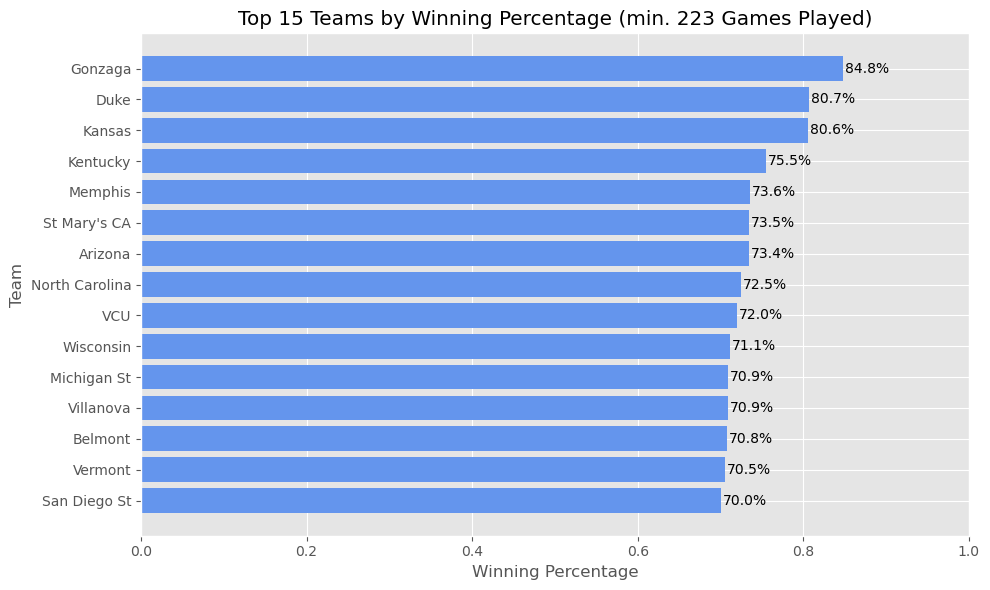

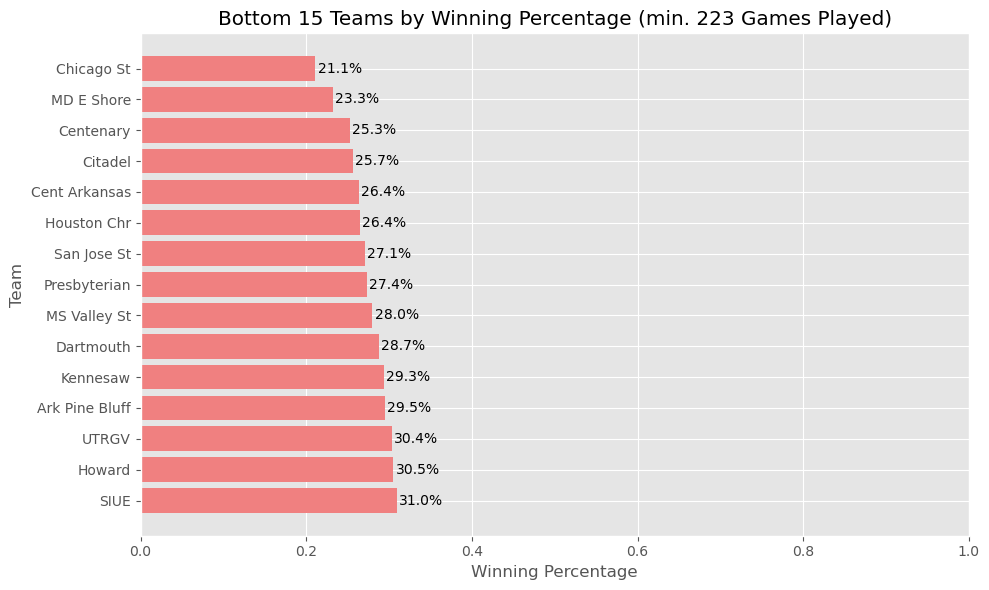

In [508]:
figsize = (10, 6)

# Get teams above min games threshold
above_threshold = team_win_pct[team_win_pct['GamesPlayed'] >= min_games]

# top / bottom n teams
n = 15

# Plot horizontal bar chart for highest winning %s in the dataset
top_teams = above_threshold.sort_values('WinningPercentage', ascending=False).head(n)

fig, ax = plt.subplots(figsize=figsize)
ax.barh(top_teams.index, top_teams['WinningPercentage'], color='cornflowerblue')
ax.set_title(f"Top {n} Teams by Winning Percentage (min. {min_games:.0f} Games Played)")
ax.set_xlabel("Winning Percentage")
ax.set_ylabel("Team")
ax.set_xlim(0, 1)
ax.invert_yaxis()

# Add data labels
for i, v in enumerate(top_teams['WinningPercentage']):
    ax.text(v + 0.0025, i, f"{v * 100:.1f}%", va='center')

plt.tight_layout()
plt.show()


# Plot horizontal bar chart for lowest winning %s in the dataset
bottom_teams = above_threshold.sort_values('WinningPercentage', ascending=True).head(n)

fig, ax = plt.subplots(figsize=figsize)
ax.barh(bottom_teams.index, bottom_teams['WinningPercentage'], color='lightcoral')
ax.set_title(f"Bottom {n} Teams by Winning Percentage (min. {min_games:.0f} Games Played)")
ax.set_xlabel("Winning Percentage")
ax.set_ylabel("Team")
ax.set_xlim(0, 1)
ax.invert_yaxis()

# Add data labels
for i, v in enumerate(bottom_teams['WinningPercentage']):
    ax.text(v + 0.0025, i, f"{v * 100:.1f}%", va='center')

plt.tight_layout()
plt.show()

***
### <a id='toc1_6_2_'></a>[Total Wins/Losses and Winning Percentage](#toc0_)

When comparing teams with the most regular season wins to those with the highest winning percentages, there is significant overlap. Programs like `Gonzaga`, `Duke`, `Kansas`, and `Kentucky` appear at the top of both lists, reflecting not only sustained success over the 22-year period but also a high level of efficiency. These teams have both longevity and consistent performance, suggesting strong recruiting pipelines, coaching stability, and program resources.

Interestingly, a few high-efficiency programs with fewer total wins—such as `Belmont`, `Vermont`, and `San Diego State`—appear in the winning percentage top 15 but not the total wins list. This suggests they have been highly successful within their schedules but may not have the same historical volume of games or national exposure as the traditional powerhouses.

A similar pattern holds among the teams with the most regular season losses and those with the lowest winning percentages. Schools like `Chicago State`, `Mississippi Valley State`, `Maryland Eastern Shore`, and `San Jose State` rank near the bottom by both metrics. This consistency across metrics indicates prolonged struggles, likely due to structural disadvantages such as limited resources and/or weaker recruiting power.

In both cases, total outcomes and efficiency metrics largely align, as the teams that win the most also tend to win at the highest rates, and those that lose the most also tend to have the lowest winning percentages. While there are exceptions, this overlap reinforces the broader trends of program-level consistency, whether strong or weak, over time.

***
## <a id='toc1_7_'></a>[Massey Ordinals](#toc0_)

Compiled by Kenneth Massey, the **Massey Ordinals** represent an ensemble of independently derived team ranking systems, each grounded in distinct statistical methodologies — from margin-of-victory models to predictive power ratings and tempo-free efficiency metrics. These ordinal rankings provide  a diverse set of quantitative perspectives on team strength and quality.

**KenPom:** Created by Ken Pomeroy, KenPom is one of the most widely respected college basketball analytics systems. It uses tempo-free statistics to evaluate team performance, emphasizing efficiency on both offense and defense while adjusting for strength of schedule. 
***

In [509]:
ordinals_df = pd.read_csv('./Data/MMasseyOrdinals.csv', dtype={'TeamID': str})

In [510]:
ordinals_df.head()

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260


In [511]:
# ordinals_df['SystemName'].unique()

# orignal_sys = ordinals_df[ordinals_df['Season'] == 2003]['SystemName'].unique()
# curr_sys = ordinals_df[ordinals_df['Season'] == 2025]['SystemName'].unique()

# set_intersection = set(curr_sys) & set(orignal_sys)
# set_intersection

In [512]:
# Extract KenPom Ratings from ordinals
kenpom = ordinals_df[ordinals_df['SystemName'] == 'POM'].rename(columns={'RankingDayNum': 'DayNum', 'OrdinalRank': 'KenPomRank'})
kenpom = kenpom.drop(columns='SystemName')
kenpom

,Season,DayNum,TeamID,KenPomRank
2968,2003,37,1102,104
2969,2003,37,1103,191
2970,2003,37,1104,15
2971,2003,37,1105,319
2972,2003,37,1106,170
...,...,...,...,...
5560304,2025,133,1476,322
5560305,2025,133,1477,330
5560306,2025,133,1478,354
5560307,2025,133,1479,342


To efficiently align KenPom ratings with each game, we construct a complete grid of every `TeamID`, `Season`, and `DayNum` in the schedule. Since KenPom updates are only available weekly, we forward-fill each team’s rating across all days to ensure that every game can be matched with the most recent available rating.

In [513]:
# Create a full grid of every (Season, TeamID, DayNum)
all_days = pd.DataFrame({'DayNum': range(134)})
teams_seasons = kenpom[['Season', 'TeamID']].drop_duplicates()
full_grid = teams_seasons.merge(all_days, how='cross')

# Merge in available KenPom data
full_kenpom = full_grid.merge(kenpom, on=['Season', 'TeamID', 'DayNum'], how='left')
full_kenpom = full_kenpom.sort_values(['Season', 'TeamID', 'DayNum'])

# Fill missing values by carrying forward the last known rank, then backfilling from the future if needed
full_kenpom['KenPomRank'] = (
    full_kenpom
    .groupby(['Season', 'TeamID'])['KenPomRank']
    .transform(lambda x: x.ffill().bfill())
)

In [514]:
# Merge KenPom rankings for TeamID
reg_combined_df = reg_combined_df.merge(
    full_kenpom,
    on=['Season', 'TeamID', 'DayNum'],
    how='left'
)

# Merge KenPom rankings for OppTeamID
full_kenpom_opp = full_kenpom.rename(columns={'TeamID': 'OppTeamID', 'KenPomRank': 'OppKenPomRank'})
reg_combined_df = reg_combined_df.merge(
    full_kenpom_opp,
    on=['Season', 'OppTeamID', 'DayNum'],
    how='left'
)

In [515]:
display(reg_combined_df[reg_combined_df.isna().any(axis=1)]['Season'].value_counts())
display(reg_combined_df[reg_combined_df['KenPomRank'].isna()][['TeamName', 'TeamID']].value_counts())

Season
2009    80
2008    20
Name: count, dtype: int64

TeamName      TeamID
Seattle       1370      21
North Dakota  1315      15
South Dakota  1377      12
Houston Chr   1223      10
Name: count, dtype: int64

In [516]:
percent_affected = len(reg_combined_df[reg_combined_df.isna().any(axis=1)]) / len(reg_combined_df) * 100
print(f"The percent of rows affected by missing KenPom values: {percent_affected:.2f}%")

The percent of rows affected by missing KenPom values: 0.04%


***
### <a id='toc1_7_1_'></a>[Missing KenPom Data for Select Schools (2008–2009)](#toc0_)

The following schools are missing from the KenPom ratings dataset during the 2008–2009 seasons:

- Seattle University (TeamID: 1370)
- University of North Dakota (TeamID: 1315)
- University of South Dakota (TeamID: 1377)
- Houston Christian University (formerly Houston Baptist, TeamID: 1223)

After further research, the missing values can be attributed to these programs either actively transitioning to NCAA Division I or having recently joined but not yet being eligible for inclusion in KenPom's ratings.

To ensure these teams are included in modeling without introducing NaNs, we impute their missing `KenPomRank` by assigning them the maximum KenPom rating for that corresponding season plus 1, effectively treating them as the lowest-ranked teams in the system. 
***

In [517]:
# Affected Seasons
seasons = [2008, 2009]

for season in seasons:

    # Find max KenPomRank for that season (i.e., lowest ranked team)
    max_kenpom = reg_combined_df.loc[reg_combined_df['Season'] == season]['KenPomRank'].max()

    # Fill missing KenPomRank values with max + 1
    reg_combined_df.loc[
        (reg_combined_df['Season'] == season) & (reg_combined_df['KenPomRank'].isna()),
        'KenPomRank'
    ] = max_kenpom + 1

    # Fill missing OppKenPomRank with max + 1
    reg_combined_df.loc[
    (reg_combined_df['Season'] == season) & (reg_combined_df['OppKenPomRank'].isna()),
    'OppKenPomRank'
] = max_kenpom + 1

# Create KenPom difference columns
reg_combined_df['KenPomDiff'] = reg_combined_df['KenPomRank'] - reg_combined_df['OppKenPomRank']
reg_combined_df['OppKenPomDiff'] = -reg_combined_df['KenPomDiff']

In [518]:
reg_combined_df.isna().sum().sum()

np.int64(0)

In [519]:
reg_combined_df

,Season,DayNum,TeamID,TeamName,OppTeamID,OppTeamName,Score,OppScore,Loc,OppLoc,NumOT,FGM,FGA,FGM3,FGA3,FTM,FTA,OR,DR,Ast,TO,Stl,Blk,PF,OppFGM,OppFGA,OppFGM3,OppFGA3,OppFTM,OppFTA,OppOR,OppDR,OppAst,OppTO,OppStl,OppBlk,OppPF,GameResult,Win,FG_Percentage,FG3_Percentage,FT_Percentage,Ast_TO_Ratio,OppFG_Percentage,OppFG3_Percentage,OppFT_Percentage,OppAst_TO_Ratio,Poss,OppPoss,OffEff,DefEff,OppOffEff,OppDefEff,Score_Diff,FGM_Diff,FGA_Diff,FGM3_Diff,FGA3_Diff,FTM_Diff,FTA_Diff,OR_Diff,DR_Diff,Ast_Diff,TO_Diff,Stl_Diff,Blk_Diff,PF_Diff,Poss_Diff,OffEff_Diff,DefEff_Diff,Score_Diff_Pct,FGM_Diff_Pct,FGA_Diff_Pct,FGM3_Diff_Pct,FGA3_Diff_Pct,FTM_Diff_Pct,FTA_Diff_Pct,OR_Diff_Pct,DR_Diff_Pct,Ast_Diff_Pct,TO_Diff_Pct,Stl_Diff_Pct,Blk_Diff_Pct,PF_Diff_Pct,Poss_Diff_Pct,OffEff_Diff_Pct,DefEff_Diff_Pct,Score_Diff_Opp,FGM_Diff_Opp,FGA_Diff_Opp,FGM3_Diff_Opp,FGA3_Diff_Opp,FTM_Diff_Opp,FTA_Diff_Opp,OR_Diff_Opp,DR_Diff_Opp,Ast_Diff_Opp,TO_Diff_Opp,Stl_Diff_Opp,Blk_Diff_Opp,PF_Diff_Opp,Poss_Diff_Opp,OffEff_Diff_Opp,DefEff_Diff_Opp,Score_Diff_Pct_Opp,FGM_Diff_Pct_Opp,FGA_Diff_Pct_Opp,FGM3_Diff_Pct_Opp,FGA3_Diff_Pct_Opp,FTM_Diff_Pct_Opp,FTA_Diff_Pct_Opp,OR_Diff_Pct_Opp,DR_Diff_Pct_Opp,Ast_Diff_Pct_Opp,TO_Diff_Pct_Opp,Stl_Diff_Pct_Opp,Blk_Diff_Pct_Opp,PF_Diff_Pct_Opp,Poss_Diff_Pct_Opp,OffEff_Diff_Pct_Opp,DefEff_Diff_Pct_Opp,KenPomRank,OppKenPomRank,KenPomDiff,OppKenPomDiff
0,2003,10,1104,Alabama,1328,Oklahoma,68,62,N,N,0,27,58,3,14,11,18,14,24,13,23,7,1,22,22,53,2,10,16,22,10,22,8,18,9,2,20,W,1,0.465517,0.214286,0.611111,0.565217,0.415094,0.200000,0.727273,0.444444,75.550,71.450,0.900066,0.867740,0.867740,0.900066,6,5,5,1,4,-5,-4,4,2,5,5,-2,-1,2,4.100,0.032327,-0.032327,0.096774,0.227273,0.094340,0.500000,0.400000,-0.312500,-0.181818,0.400000,0.090909,0.625000,0.277778,-0.222222,-0.500000,0.100000,0.057383,0.037254,-0.035916,-6,-5,-5,-1,-4,5,4,-4,-2,-5,-5,2,1,-2,-4.100,-0.032327,0.032327,-0.096774,-0.227273,-0.094340,-0.500000,-0.400000,0.312500,0.181818,-0.400000,-0.090909,-0.625000,-0.277778,0.222222,0.500000,-0.100000,-0.057383,-0.037254,0.035916,15.0,20.0,-5.0,5.0
1,2003,10,1272,Memphis,1393,Syracuse,70,63,N,N,0,26,62,8,20,10,19,15,28,16,13,4,4,18,24,67,6,24,9,20,20,25,7,12,8,6,16,W,1,0.419355,0.400000,0.526316,1.230769,0.358209,0.250000,0.450000,0.583333,69.025,68.500,1.014125,0.919708,0.919708,1.014125,7,2,-5,2,-4,1,-1,-5,3,9,1,-4,-2,2,0.525,0.094417,-0.094417,0.111111,0.083333,-0.074627,0.333333,-0.166667,0.111111,-0.050000,-0.250000,0.120000,1.285714,0.083333,-0.500000,-0.333333,0.125000,0.007664,0.102660,-0.093102,-7,-2,5,-2,4,-1,1,5,-3,-9,-1,4,2,-2,-0.525,-0.094417,0.094417,-0.111111,-0.083333,0.074627,-0.333333,0.166667,-0.111111,0.050000,0.250000,-0.120000,-1.285714,-0.083333,0.500000,0.333333,-0.125000,-0.007664,-0.102660,0.093102,41.0,40.0,1.0,-1.0
2,2003,11,1266,Marquette,1437,Villanova,73,61,N,N,0,24,58,8,18,17,29,17,26,15,10,5,2,25,22,73,3,26,14,23,31,22,9,12,2,5,23,W,1,0.413793,0.444444,0.586207,1.500000,0.301370,0.115385,0.608696,0.750000,64.775,64.925,1.126978,0.939546,0.939546,1.126978,12,2,-15,5,-8,3,6,-14,4,6,-2,3,-3,2,-0.150,0.187432,-0.187432,0.196721,0.090909,-0.205479,1.666667,-0.307692,0.214286,0.260870,-0.451613,0.181818,0.666667,-0.166667,1.500000,-0.600000,0.086957,-0.002310,0.199493,-0.166314,-12,-2,15,-5,8,-3,-6,14,-4,-6,2,-3,3,-2,0.150,-0.187432,0.187432,-0.196721,-0.090909,0.205479,-1.666667,0.307692,-0.214286,-0.260870,0.451613,-0.181818,-0.666667,0.166667,-1.500000,0.600000,-0.086957,0.002310,-0.199493,0.166314,25.0,46.0,-21.0,21.0
3,2003,11,1296,N Illinois,1457,Winthrop,56,50,N,N,0,18,38,3,9,17,31,6,19,11,12,14,2,18,18,49,6,22,8,15,17,20,9,19,4,3,23,W,1,0.473684,0.333333,0.548387,0.916667,0.367347,0.272727,0.533333,0.473684,58.725,58.125,0.953597,0.860215,0.860215,0.953597,6,0,-11,-3,-13,9,16,-11,-1,2,-7,10,-1,-5,0.600,0.093382,-0.093382,0.120000,0.000000,-0.224490,-0.500000,-0.590909,1.125000,1.066667,-0.647059,-0.050000,0.222222,-0.368421,2.500000,-0.333333,-0.217391,0.010323,0.108557,-0.097926,-6,0,11,3,13,-9,

***
## <a id='toc1_8_'></a>[Aggregation Statistics](#toc0_)

Now that our dataset is structured properly, we can meaningfully aggregate statistics at the **season-team level**. This aggregation forms the foundation for all subsequent analyses.

### <a id='toc1_8_1_'></a>[Season-Level Aggregates](#toc0_)

For each `TeamID` and `Season`, we compute:

- **Overall Statistics (`*_PerGame`)**: calculated across all games
- **Winning Statistics (`*_PerWin`)**: calculated only from games the team won
- **Losing Statistics (`*_PerLoss`)**: calculated only from games the team lost
- **Summary Stats**:
  - `TotalGames`: Number of games played
  - `TotalWins` and `TotalLosses`
  - `WinningPercentage`: Win rate as `TotalWins / TotalGames`

This aggregation provides a complete picture of team performance and allows us to explore how performance differs in wins versus losses—crucial for understanding what drives success.

The full aggregation logic is implemented in the `compute_aggregates()` function, which merges each set of metrics (`PerGame`, `PerWin`, `PerLoss`) into a final season-level dataframe and fills in zeros for teams that had no wins or no losses (winless and undefeated teams).

This approach is particularly useful for modeling and exploratory data analysis, where separating performance by game outcome (win/loss) can yield deeper insights.
***

In [520]:
numeric_cols = reg_combined_df.select_dtypes(include=["number"]).columns.tolist()
exclude = ['Season', 'DayNum']
numeric_cols = [col for col in numeric_cols if col not in exclude]

In [521]:
def compute_aggregates(df):
    """
    Aggregates stats at the season level.
    - Computes total stats (all games)
    - Computes stats for wins/losses separately
    - Computes opponent aggregate stats
    """
    
    # Total season averages (all games)
    total_stats = df.groupby(["Season", "TeamID"])[numeric_cols].mean().reset_index()
    total_stats = total_stats.rename(columns=lambda x: f"{x}_PerGame" if x not in ["Season", "TeamID"] else x)

    # Winning game averages
    win_stats = df[df["Win"] == 1].groupby(["Season", "TeamID"])[numeric_cols].mean().reset_index()
    win_stats = win_stats.rename(columns=lambda x: f"{x}_PerWin" if x not in ["Season", "TeamID"] else x)

    # Losing game averages
    loss_stats = df[df["Win"] == 0].groupby(["Season", "TeamID"])[numeric_cols].mean().reset_index()
    loss_stats = loss_stats.rename(columns=lambda x: f"{x}_PerLoss" if x not in ["Season", "TeamID"] else x)

    # Total Games Played (count occurrences of TeamID)
    total_games = df.groupby(["Season", "TeamID"]).size().reset_index(name="TotalGames")
    total_wins = df.groupby(["Season", "TeamID"])["Win"].sum().reset_index().rename(columns={"Win": "TotalWins"})
    
    summary_stats = total_games.merge(total_wins, on=["Season", "TeamID"])
    summary_stats["TotalLosses"] = summary_stats["TotalGames"] - summary_stats["TotalWins"]
    summary_stats["WinningPercentage"] = summary_stats["TotalWins"] / summary_stats["TotalGames"]

    team_season_stats = (
        summary_stats
        .merge(total_stats, on=["Season", "TeamID"], how="left")
        .merge(win_stats, on=["Season", "TeamID"], how="left")
        .merge(loss_stats, on=["Season", "TeamID"], how="left")

    )

    # Fill missing values with 0 for teams that had 0 wins or 0 losses
    team_season_stats = team_season_stats.fillna(0)

    return team_season_stats

In [522]:
# Compute aggregatations
reg_team_stats = compute_aggregates(reg_combined_df)

In [523]:
print(reg_team_stats.shape)
print(f"Missing values: {reg_team_stats.isna().sum().sum()}")
display(reg_team_stats.head())

(7981, 354)
Missing values: 0


,Season,TeamID,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,NumOT_PerGame,FGM_PerGame,FGA_PerGame,FGM3_PerGame,FGA3_PerGame,FTM_PerGame,FTA_PerGame,OR_PerGame,DR_PerGame,Ast_PerGame,TO_PerGame,Stl_PerGame,Blk_PerGame,PF_PerGame,OppFGM_PerGame,OppFGA_PerGame,OppFGM3_PerGame,OppFGA3_PerGame,OppFTM_PerGame,OppFTA_PerGame,OppOR_PerGame,OppDR_PerGame,OppAst_PerGame,OppTO_PerGame,OppStl_PerGame,OppBlk_PerGame,OppPF_PerGame,Win_PerGame,FG_Percentage_PerGame,FG3_Percentage_PerGame,FT_Percentage_PerGame,Ast_TO_Ratio_PerGame,OppFG_Percentage_PerGame,OppFG3_Percentage_PerGame,OppFT_Percentage_PerGame,OppAst_TO_Ratio_PerGame,Poss_PerGame,OppPoss_PerGame,OffEff_PerGame,DefEff_PerGame,OppOffEff_PerGame,OppDefEff_PerGame,Score_Diff_PerGame,FGM_Diff_PerGame,FGA_Diff_PerGame,FGM3_Diff_PerGame,FGA3_Diff_PerGame,FTM_Diff_PerGame,FTA_Diff_PerGame,OR_Diff_PerGame,DR_Diff_PerGame,Ast_Diff_PerGame,TO_Diff_PerGame,Stl_Diff_PerGame,Blk_Diff_PerGame,PF_Diff_PerGame,Poss_Diff_PerGame,OffEff_Diff_PerGame,DefEff_Diff_PerGame,Score_Diff_Pct_PerGame,FGM_Diff_Pct_PerGame,FGA_Diff_Pct_PerGame,FGM3_Diff_Pct_PerGame,FGA3_Diff_Pct_PerGame,FTM_Diff_Pct_PerGame,FTA_Diff_Pct_PerGame,OR_Diff_Pct_PerGame,DR_Diff_Pct_PerGame,Ast_Diff_Pct_PerGame,TO_Diff_Pct_PerGame,Stl_Diff_Pct_PerGame,Blk_Diff_Pct_PerGame,PF_Diff_Pct_PerGame,Poss_Diff_Pct_PerGame,OffEff_Diff_Pct_PerGame,DefEff_Diff_Pct_PerGame,Score_Diff_Opp_PerGame,FGM_Diff_Opp_PerGame,FGA_Diff_Opp_PerGame,FGM3_Diff_Opp_PerGame,FGA3_Diff_Opp_PerGame,FTM_Diff_Opp_PerGame,FTA_Diff_Opp_PerGame,OR_Diff_Opp_PerGame,DR_Diff_Opp_PerGame,Ast_Diff_Opp_PerGame,TO_Diff_Opp_PerGame,Stl_Diff_Opp_PerGame,Blk_Diff_Opp_PerGame,PF_Diff_Opp_PerGame,Poss_Diff_Opp_PerGame,OffEff_Diff_Opp_PerGame,DefEff_Diff_Opp_PerGame,Score_Diff_Pct_Opp_PerGame,FGM_Diff_Pct_Opp_PerGame,FGA_Diff_Pct_Opp_PerGame,FGM3_Diff_Pct_Opp_PerGame,FGA3_Diff_Pct_Opp_PerGame,FTM_Diff_Pct_Opp_PerGame,FTA_Diff_Pct_Opp_PerGame,OR_Diff_Pct_Opp_PerGame,DR_Diff_Pct_Opp_PerGame,Ast_Diff_Pct_Opp_PerGame,TO_Diff_Pct_Opp_PerGame,Stl_Diff_Pct_Opp_PerGame,Blk_Diff_Pct_Opp_PerGame,PF_Diff_Pct_Opp_PerGame,Poss_Diff_Pct_Opp_PerGame,OffEff_Diff_Pct_Opp_PerGame,DefEff_Diff_Pct_Opp_PerGame,KenPomRank_PerGame,OppKenPomRank_PerGame,KenPomDiff_PerGame,OppKenPomDiff_PerGame,Score_PerWin,OppScore_PerWin,NumOT_PerWin,FGM_PerWin,FGA_PerWin,FGM3_PerWin,FGA3_PerWin,FTM_PerWin,FTA_PerWin,OR_PerWin,DR_PerWin,Ast_PerWin,TO_PerWin,Stl_PerWin,Blk_PerWin,PF_PerWin,OppFGM_PerWin,OppFGA_PerWin,OppFGM3_PerWin,OppFGA3_PerWin,OppFTM_PerWin,OppFTA_PerWin,OppOR_PerWin,OppDR_PerWin,OppAst_PerWin,OppTO_PerWin,OppStl_PerWin,OppBlk_PerWin,OppPF_PerWin,Win_PerWin,FG_Percentage_PerWin,FG3_Percentage_PerWin,FT_Percentage_PerWin,Ast_TO_Ratio_PerWin,OppFG_Percentage_PerWin,OppFG3_Percentage_PerWin,OppFT_Percentage_PerWin,OppAst_TO_Ratio_PerWin,Poss_PerWin,OppPoss_PerWin,OffEff_PerWin,DefEff_PerWin,OppOffEff_PerWin,OppDefEff_PerWin,Score_Diff_PerWin,FGM_Diff_PerWin,FGA_Diff_PerWin,FGM3_Diff_PerWin,FGA3_Diff_PerWin,FTM_Diff_PerWin,FTA_Diff_PerWin,OR_Diff_PerWin,DR_Diff_PerWin,Ast_Diff_PerWin,TO_Diff_PerWin,Stl_Diff_PerWin,Blk_Diff_PerWin,PF_Diff_PerWin,Poss_Diff_PerWin,OffEff_Diff_PerWin,DefEff_Diff_PerWin,Score_Diff_Pct_PerWin,FGM_Diff_Pct_PerWin,FGA_Diff_Pct_PerWin,FGM3_Diff_Pct_PerWin,FGA3_Diff_Pct_PerWin,FTM_Diff_Pct_PerWin,FTA_Diff_Pct_PerWin,OR_Diff_Pct_PerWin,DR_Diff_Pct_PerWin,Ast_Diff_Pct_PerWin,TO_Diff_Pct_PerWin,Stl_Diff_Pct_PerWin,Blk_Diff_Pct_PerWin,PF_Diff_Pct_PerWin,Poss_Diff_Pct_PerWin,OffEff_Diff_Pct_PerWin,DefEff_Diff_Pct_PerWin,Score_Diff_Opp_PerWin,FGM_Diff_Opp_PerWin,FGA_Diff_Opp_PerWin,FGM3_Diff_Opp_PerWin,FGA3_Diff_Opp_PerWin,FTM_Diff_Opp_PerWin,FTA_Diff_Opp_PerWin,OR_Diff_Opp_PerWin,DR_Diff_Opp_PerWin,Ast_Diff_Opp_PerWin,TO_Diff_Opp_PerWin,Stl_Diff_Opp_PerWin,Blk_Diff_Opp_PerWin,PF_Diff_Opp_PerWin,Poss_Diff_Opp_PerWin,OffEff_Diff_Opp_PerWin,DefEff_Diff_Opp_PerWin,Score_Diff_Pct_Opp_PerWin,FGM_Diff_Pct_Opp_PerWin,FGA_Diff_Pct_Opp_PerWin,FGM3_Diff_Pct_Opp_P

In [524]:
regular_season_stats = team_info.merge(reg_team_stats, on=["Season", "TeamID"])

print(regular_season_stats.shape)
print(f"Missing values: {regular_season_stats.isna().sum().sum()}")
display(regular_season_stats.head())

(7981, 357)
Missing values: 0


,Season,TeamID,TeamName,ConfAbbrev,Description,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,NumOT_PerGame,FGM_PerGame,FGA_PerGame,FGM3_PerGame,FGA3_PerGame,FTM_PerGame,FTA_PerGame,OR_PerGame,DR_PerGame,Ast_PerGame,TO_PerGame,Stl_PerGame,Blk_PerGame,PF_PerGame,OppFGM_PerGame,OppFGA_PerGame,OppFGM3_PerGame,OppFGA3_PerGame,OppFTM_PerGame,OppFTA_PerGame,OppOR_PerGame,OppDR_PerGame,OppAst_PerGame,OppTO_PerGame,OppStl_PerGame,OppBlk_PerGame,OppPF_PerGame,Win_PerGame,FG_Percentage_PerGame,FG3_Percentage_PerGame,FT_Percentage_PerGame,Ast_TO_Ratio_PerGame,OppFG_Percentage_PerGame,OppFG3_Percentage_PerGame,OppFT_Percentage_PerGame,OppAst_TO_Ratio_PerGame,Poss_PerGame,OppPoss_PerGame,OffEff_PerGame,DefEff_PerGame,OppOffEff_PerGame,OppDefEff_PerGame,Score_Diff_PerGame,FGM_Diff_PerGame,FGA_Diff_PerGame,FGM3_Diff_PerGame,FGA3_Diff_PerGame,FTM_Diff_PerGame,FTA_Diff_PerGame,OR_Diff_PerGame,DR_Diff_PerGame,Ast_Diff_PerGame,TO_Diff_PerGame,Stl_Diff_PerGame,Blk_Diff_PerGame,PF_Diff_PerGame,Poss_Diff_PerGame,OffEff_Diff_PerGame,DefEff_Diff_PerGame,Score_Diff_Pct_PerGame,FGM_Diff_Pct_PerGame,FGA_Diff_Pct_PerGame,FGM3_Diff_Pct_PerGame,FGA3_Diff_Pct_PerGame,FTM_Diff_Pct_PerGame,FTA_Diff_Pct_PerGame,OR_Diff_Pct_PerGame,DR_Diff_Pct_PerGame,Ast_Diff_Pct_PerGame,TO_Diff_Pct_PerGame,Stl_Diff_Pct_PerGame,Blk_Diff_Pct_PerGame,PF_Diff_Pct_PerGame,Poss_Diff_Pct_PerGame,OffEff_Diff_Pct_PerGame,DefEff_Diff_Pct_PerGame,Score_Diff_Opp_PerGame,FGM_Diff_Opp_PerGame,FGA_Diff_Opp_PerGame,FGM3_Diff_Opp_PerGame,FGA3_Diff_Opp_PerGame,FTM_Diff_Opp_PerGame,FTA_Diff_Opp_PerGame,OR_Diff_Opp_PerGame,DR_Diff_Opp_PerGame,Ast_Diff_Opp_PerGame,TO_Diff_Opp_PerGame,Stl_Diff_Opp_PerGame,Blk_Diff_Opp_PerGame,PF_Diff_Opp_PerGame,Poss_Diff_Opp_PerGame,OffEff_Diff_Opp_PerGame,DefEff_Diff_Opp_PerGame,Score_Diff_Pct_Opp_PerGame,FGM_Diff_Pct_Opp_PerGame,FGA_Diff_Pct_Opp_PerGame,FGM3_Diff_Pct_Opp_PerGame,FGA3_Diff_Pct_Opp_PerGame,FTM_Diff_Pct_Opp_PerGame,FTA_Diff_Pct_Opp_PerGame,OR_Diff_Pct_Opp_PerGame,DR_Diff_Pct_Opp_PerGame,Ast_Diff_Pct_Opp_PerGame,TO_Diff_Pct_Opp_PerGame,Stl_Diff_Pct_Opp_PerGame,Blk_Diff_Pct_Opp_PerGame,PF_Diff_Pct_Opp_PerGame,Poss_Diff_Pct_Opp_PerGame,OffEff_Diff_Pct_Opp_PerGame,DefEff_Diff_Pct_Opp_PerGame,KenPomRank_PerGame,OppKenPomRank_PerGame,KenPomDiff_PerGame,OppKenPomDiff_PerGame,Score_PerWin,OppScore_PerWin,NumOT_PerWin,FGM_PerWin,FGA_PerWin,FGM3_PerWin,FGA3_PerWin,FTM_PerWin,FTA_PerWin,OR_PerWin,DR_PerWin,Ast_PerWin,TO_PerWin,Stl_PerWin,Blk_PerWin,PF_PerWin,OppFGM_PerWin,OppFGA_PerWin,OppFGM3_PerWin,OppFGA3_PerWin,OppFTM_PerWin,OppFTA_PerWin,OppOR_PerWin,OppDR_PerWin,OppAst_PerWin,OppTO_PerWin,OppStl_PerWin,OppBlk_PerWin,OppPF_PerWin,Win_PerWin,FG_Percentage_PerWin,FG3_Percentage_PerWin,FT_Percentage_PerWin,Ast_TO_Ratio_PerWin,OppFG_Percentage_PerWin,OppFG3_Percentage_PerWin,OppFT_Percentage_PerWin,OppAst_TO_Ratio_PerWin,Poss_PerWin,OppPoss_PerWin,OffEff_PerWin,DefEff_PerWin,OppOffEff_PerWin,OppDefEff_PerWin,Score_Diff_PerWin,FGM_Diff_PerWin,FGA_Diff_PerWin,FGM3_Diff_PerWin,FGA3_Diff_PerWin,FTM_Diff_PerWin,FTA_Diff_PerWin,OR_Diff_PerWin,DR_Diff_PerWin,Ast_Diff_PerWin,TO_Diff_PerWin,Stl_Diff_PerWin,Blk_Diff_PerWin,PF_Diff_PerWin,Poss_Diff_PerWin,OffEff_Diff_PerWin,DefEff_Diff_PerWin,Score_Diff_Pct_PerWin,FGM_Diff_Pct_PerWin,FGA_Diff_Pct_PerWin,FGM3_Diff_Pct_PerWin,FGA3_Diff_Pct_PerWin,FTM_Diff_Pct_PerWin,FTA_Diff_Pct_PerWin,OR_Diff_Pct_PerWin,DR_Diff_Pct_PerWin,Ast_Diff_Pct_PerWin,TO_Diff_Pct_PerWin,Stl_Diff_Pct_PerWin,Blk_Diff_Pct_PerWin,PF_Diff_Pct_PerWin,Poss_Diff_Pct_PerWin,OffEff_Diff_Pct_PerWin,DefEff_Diff_Pct_PerWin,Score_Diff_Opp_PerWin,FGM_Diff_Opp_PerWin,FGA_Diff_Opp_PerWin,FGM3_Diff_Opp_PerWin,FGA3_Diff_Opp_PerWin,FTM_Diff_Opp_PerWin,FTA_Diff_Opp_PerWin,OR_Diff_Opp_PerWin,DR_Diff_Opp_PerWin,Ast_Diff_Opp_PerWin,TO_Diff_Opp_PerWin,Stl_Diff_Opp_PerWin,Blk_Diff_Opp_PerWin,PF_Diff_Opp_PerWin,Poss_Diff_Opp_PerWin,OffEff_Diff_Opp_PerWin,DefEff_Diff_Opp_PerWin,Score_Diff_Pct_Opp_PerWin,FGM_Diff_Pct_Opp_PerWin,FGA_Diff_Pc

In [525]:
# Checkpoint - Save df to csv
regular_season_stats.to_csv('./Data/Live/RegularSeasonStats.csv', index=False)

***
## <a id='toc1_9_'></a>[EDA](#toc0_)

With the dataset now properly structured and enriched, we can begin a more focused exploratory data analysis (EDA).

This phase is designed to surface meaningful patterns, trends, and relationships across more than two decades of Division I men’s college basketball. By combining domain knowledge with statistical rigor, we’ll investigate how the game has evolved — from shifts in tempo and scoring efficiency to differences in team performance by conference, era, style of play, and more.

We’ll examine both macro-level dynamics (like league-wide scoring trends) and team-level behavior (e.g., how efficiency metrics relate to win rates), setting the stage for more targeted modeling and evaluation later in the pipeline.
***

### <a id='toc1_9_1_'></a>[Scoring Margin Distribution](#toc0_)
Let's first take a look at the distribution of **scoring margin** — the difference between points scored and points allowed per game.

This metric captures the net result of both offensive and defensive performance and serves as a simple but powerful indicator of overall team quality. 

In theory, teams with consistently positive scoring margins tend to win more often, while those with consistently negative margins struggle over time. But how are scoring margins distributed across all teams and seasons?

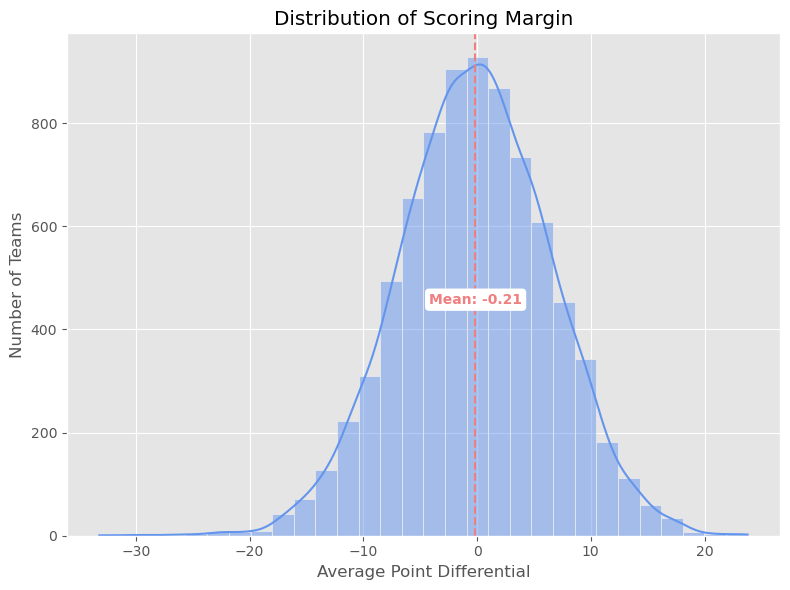

In [526]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram with KDE
sns.histplot(
    data=regular_season_stats,
    x='Score_Diff_PerGame',
    kde=True,
    bins=30,
    color='cornflowerblue',
    ax=ax
)

# Add title and labels
ax.set_title("Distribution of Scoring Margin")
ax.set_xlabel("Average Point Differential")
ax.set_ylabel("Number of Teams")

# Add vertical mean line
mean_diff = regular_season_stats['Score_Diff_PerGame'].mean()
ax.axvline(mean_diff, color='lightcoral', linestyle='--', label='Mean')

# Add mean & median data labels
ax.text(mean_diff - 4, 450, f"Mean: {mean_diff:.2f}",
        color='lightcoral', fontsize=10, fontweight='bold',
        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.show()


In [527]:
print(regular_season_stats['Score_Diff_PerGame'].describe())

count    7981.000000
mean       -0.213608
std         6.625330
min       -33.222222
25%        -4.633333
50%        -0.181818
75%         4.321429
max        23.787879
Name: Score_Diff_PerGame, dtype: float64


In [528]:
# Extract summary statistics
display(pd.DataFrame(regular_season_stats['Score_Diff_PerGame'].describe()))

cols = [
    'Season', 'TeamID','TeamName','ConfAbbrev','Description',
    'TotalGames','TotalWins', 'TotalLosses', 'WinningPercentage',
    'Score_PerGame','OppScore_PerGame', 'Score_Diff_PerGame'
    ]

# Max and Min avg. scoring differential in one season
print("Team with the highest average scoring margin in a single season:")
display(regular_season_stats.loc[[regular_season_stats['Score_Diff_PerGame'].idxmax()], cols])

print("\nTeam with the lowest average scoring margin in a single season:")
display(regular_season_stats.loc[[regular_season_stats['Score_Diff_PerGame'].idxmin()], cols])

# Threshold for # of games played
min_games_played = 20
min_played_df = regular_season_stats[regular_season_stats['TotalGames'] >= min_games_played]
print(f"\nTeam with the lowest average scoring margin (min. {min_games_played} games played):")
display(min_played_df.loc[[min_played_df['Score_Diff_PerGame'].idxmin()], cols])

,Score_Diff_PerGame
count,7981.000000
mean,-0.213608
std,6.625330
min,-33.222222
25%,-4.633333
50%,-0.181818
75%,4.321429
max,23.787879


Team with the highest average scoring margin in a single season:


,Season,TeamID,TeamName,ConfAbbrev,Description,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,Score_Diff_PerGame
5585,2019,1211,Gonzaga,WCC,West Coast Conference,33,30,3,0.909091,88.848485,65.060606,23.787879



Team with the lowest average scoring margin in a single season:


,Season,TeamID,TeamName,ConfAbbrev,Description,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,Score_Diff_PerGame
6230,2021,1152,Chicago St,WAC,Western Athletic Conference,9,0,9,0.0,55.444444,88.666667,-33.222222



Team with the lowest average scoring margin (min. 20 games played):


,Season,TeamID,TeamName,ConfAbbrev,Description,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,Score_Diff_PerGame
6361,2021,1290,MS Valley St,SWAC,Southwest Athletic Conference,24,2,22,0.083333,56.833333,87.375,-30.541667


***
### <a id='toc1_9_2_'></a>[Distribution of Average Scoring Margin](#toc0_)

The histogram and summary statistics above show a near-normal distribution of average scoring margin across all team seasons. This pattern makes intuitive sense: in aggregate, every point scored is matched by a point allowed elsewhere in the dataset. As a result, the distribution of season-level scoring margins centers around zero.

What varies is how consistently teams produce positive or negative differentials across a season. Most teams fall within a relatively narrow band around the mean, but a few notable outliers highlight the range of performance extremes:

- **Highest Average Scoring Margin**:  
  Gonzaga in the 2019 season posted the most dominant scoring differential in the dataset, outscoring opponents by an average of **+23.79 points per game**. They averaged **88.85 PPG** while allowing just **65.06 PPG**.

- **Lowest Average Scoring Margin**:  
  Chicago State in 2021 played only 9 Division I games but lost by an average of **-33.22 points per game**, scoring just **55.44 PPG** and allowing **88.67 PPG**.

- **Lowest Average Scoring Margin (min. 20 Games Played)**:  
  Mississippi Valley State in 2021 stands out as the least competitive full-season team, losing by an average of **-30.54 points per game**. They averaged **56.83 PPG** and gave up **87.38 PPG** to opponents.
***

### <a id='toc1_9_3_'></a>[Distribution of Scoring Over Time (2003–2025)](#toc0_)

The below explores longitudinal trends in points per game and playing styles in college basketball. These metrics reflect not only offensive performance but also changes in pace and strategy. By examining season-level distributions over time, we can identify key inflection points—most notably, the 2015–16 rule change that reduced the shot clock to 30 seconds—and assess their lasting impact on the tempo and structure of the game.

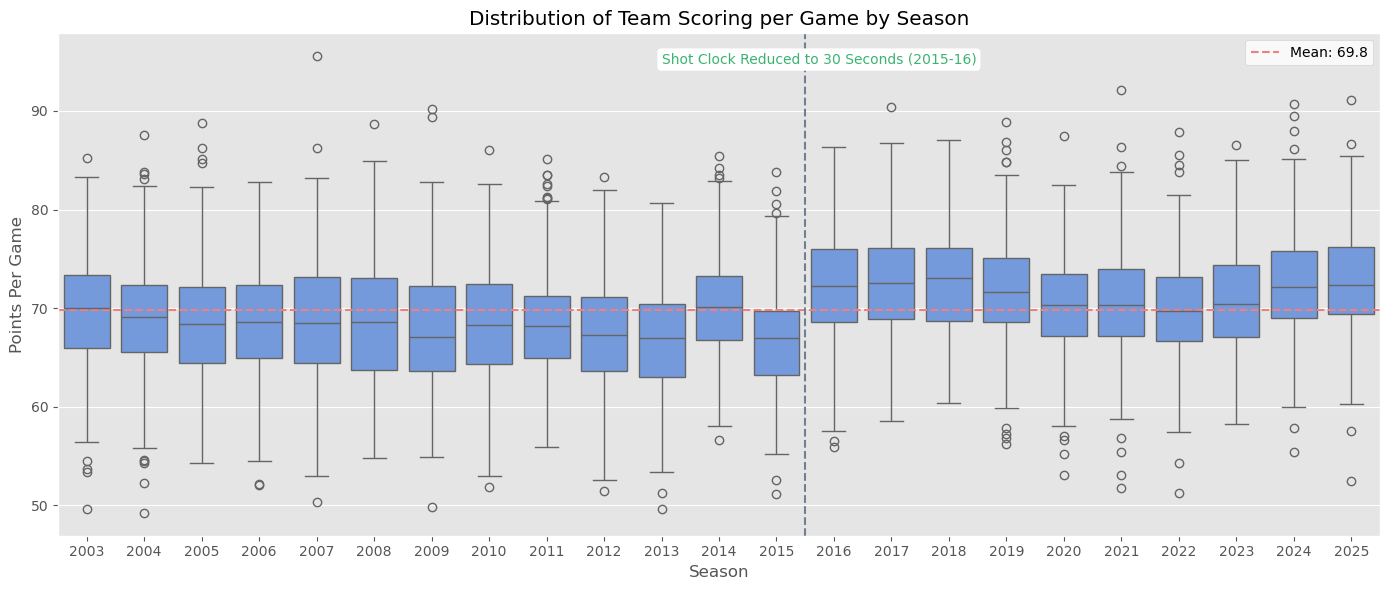

In [529]:
fig, ax = plt.subplots(figsize=(14, 6))

# Create boxplot of team scoring over time
sns.boxplot(
    data=regular_season_stats,
    x='Season',
    y='Score_PerGame',
    color='cornflowerblue',
    ax=ax
)

# Format labels and title
ax.set_title("Distribution of Team Scoring per Game by Season")
ax.set_xlabel("Season")
ax.set_ylabel("Points Per Game")
ax.tick_params(axis='x', rotation=0)

# Add horizontal line for mean
mean_ppg = regular_season_stats['Score_PerGame'].mean()
ax.axhline(mean_ppg, color='lightcoral', linestyle='--', label=f"Mean: {mean_ppg:.1f}")

# Add vertical line for 2015–16 shot clock rule change
ax.axvline(regular_season_stats['Season'].unique().tolist().index(2015) + 0.5, color='slategray', linestyle='--')

# Add annotation
ax.text(
    regular_season_stats['Season'].unique().tolist().index(2016) - 3,
    mean_ppg + 25,
    "Shot Clock Reduced to 30 Seconds (2015-16)",
    color='mediumseagreen',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')
)

legend = ax.legend()
legend.get_frame().set_facecolor('white')

plt.tight_layout()
plt.show()

In [530]:
print(f"Historical Average PPG (2003–2025): {mean_ppg:.2f} PPG")
print(f"Average PPG BEFORE rule change (≤ 2015): {regular_season_stats[regular_season_stats['Season'] <= 2015]['Score_PerGame'].mean():.2f} PPG")
print(f"Average PPG AFTER rule change (> 2015): {regular_season_stats[regular_season_stats['Season'] > 2015]['Score_PerGame'].mean():.2f} PPG")

Historical Average PPG (2003–2025): 69.80 PPG
Average PPG BEFORE rule change (≤ 2015): 68.36 PPG
Average PPG AFTER rule change (> 2015): 71.60 PPG


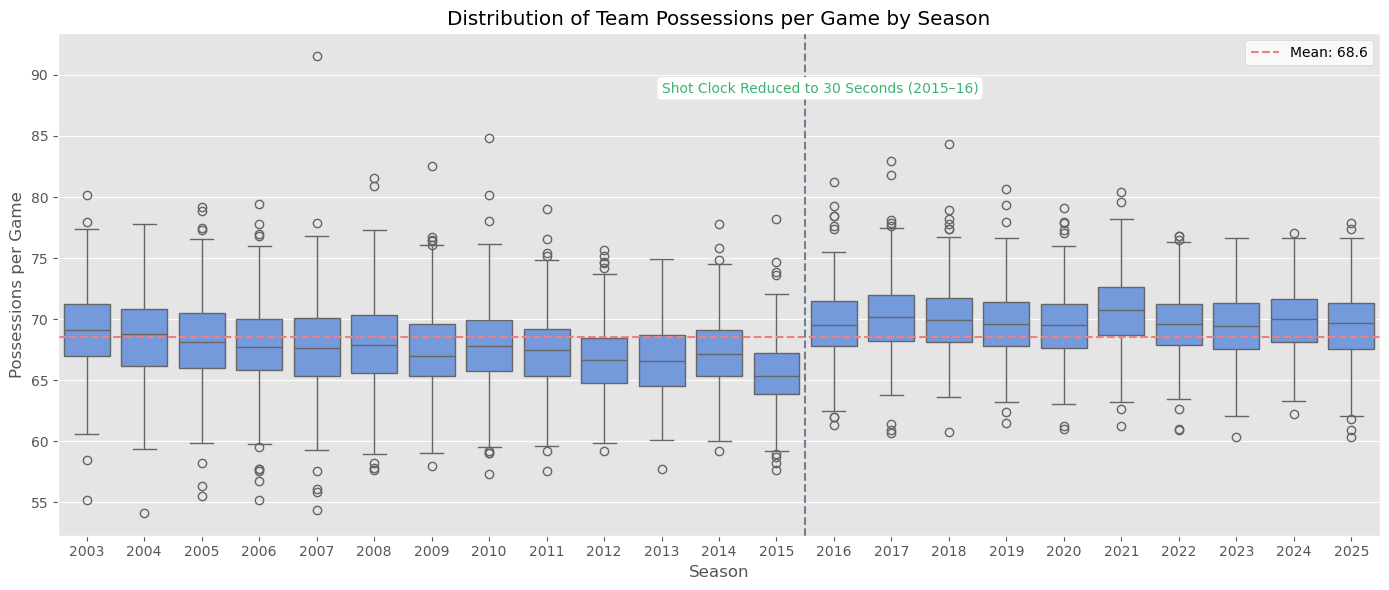

In [531]:
fig, ax = plt.subplots(figsize=(14, 6))

# Create boxplot for Possessions Per Game over time
sns.boxplot(
    data=regular_season_stats,
    x='Season',
    y='Poss_PerGame',
    color='cornflowerblue',
    ax=ax
)

ax.set_title("Distribution of Team Possessions per Game by Season")
ax.set_xlabel("Season")
ax.set_ylabel("Possessions per Game")
ax.tick_params(axis='x', rotation=0)

# Add horizontal line for mean
mean_poss = regular_season_stats['Poss_PerGame'].mean()
ax.axhline(mean_poss, color='lightcoral', linestyle='--', label=f"Mean: {mean_poss:.1f}")

# Add vertical line for 2015–16 shot clock rule change
ax.axvline(regular_season_stats['Season'].unique().tolist().index(2015) + 0.5, color='slategray', linestyle='--')

# Add annotation
ax.text(
    regular_season_stats['Season'].unique().tolist().index(2016) - 3,
    mean_poss + 20,
    "Shot Clock Reduced to 30 Seconds (2015–16)",
    color='mediumseagreen',
    fontsize=10,
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3')
)

# Add legend
legend = ax.legend()
legend.get_frame().set_facecolor('white')

plt.tight_layout()
plt.show()

In [532]:
print(f"Historical Average POSS (2003–2025): {mean_poss:.2f} PPG")
print(f"Average POSS BEFORE rule change (≤ 2015): {regular_season_stats[regular_season_stats['Season'] <= 2015]['Poss_PerGame'].mean():.2f} PPG")
print(f"Average POSS AFTER rule change (> 2015): {regular_season_stats[regular_season_stats['Season'] > 2015]['Poss_PerGame'].mean():.2f} PPG")

Historical Average POSS (2003–2025): 68.57 PPG
Average POSS BEFORE rule change (≤ 2015): 67.53 PPG
Average POSS AFTER rule change (> 2015): 69.87 PPG


***
### <a id='toc1_9_4_'></a>[Scoring and Tempo Trends Over Time (2003–2025)](#toc0_)

Scoring across Division I men’s basketball has undergone a clear structural shift. While the historical average over the 2003–2025 period was 69.8 points per game (PPG), 
this aggregate figure conceals a distinct change in scoring dynamics and obscures a sharp divide before and after 2015.

From 2003 to 2015, scoring was consistently lower, as only one season in that 13-year span (2014) exceeded the historical average. The mean during this stretch was 68.4 PPG, while the ten seasons since 2015 have averaged 71.6 PPG—an increase of nearly 5% relative to the earlier era—with 9 of those 10 seasons exceeding the long-run average.

This inflection point aligns directly with the NCAA’s 2015–16 rule change reducing the shot clock from 35 to 30 seconds. The adjustment was designed to speed up the game—and it did. Fewer seconds per possession meant more possessions per game, forcing teams to initiate offense faster and play at a higher tempo. The result: a sustained increase in scoring and a measurable change in the pace and style of play.

Tempo metrics confirm the same pattern. Average possessions per game rose from 67.5 prior to the rule change to 69.9 in the seasons that followed. This nearly 2.4 possession increase per game reflects the pace-driven nature of the scoring rise and underscores the long-term impact of the rule change on how the game is played. Possessions represent the number of discrete offensive opportunities a team has in a game—i.e., how often a team gets to try to score. As such, possessions are a key proxy for tempo: faster teams generate more possessions, while slower teams generate fewer. The increase in possessions reflects the game’s shift toward a quicker, more fluid offensive environment.
***

### <a id='toc1_9_5_'></a>[Team Performance and Playing Style](#toc0_)
With the broader trend toward higher-scoring, faster-paced basketball established, the next question is: how does playing style relate to winning? To explore this, we can look at how team success—measured by winning percentage—relates to three core components of team performance:

- Tempo (Possessions per Game): Do faster teams win more often?
- Offensive Efficiency (Points per 100 Possessions): Do the most efficient scoring teams translate that into wins?
- Defensive Efficiency (Points Allowed per 100 Possessions): Do teams that limit opponents' efficiency have higher win rates?

The following interactive scatter plots examine these relationships across all teams over the 2003–2025 period, helping identify what types of profiles are most associated with winning basketball.

In [533]:
# Create Era column for pre-2016 and post-2015
regular_season_stats['Era'] = regular_season_stats['Season'].apply(lambda x: 'Post-2015' if x > 2015 else 'Pre-2016')

# 1. Winning % vs. Possessions (per game)
fig = px.scatter(
    regular_season_stats,
    x='Poss_PerGame',
    y='WinningPercentage',
    color='Era',  # Color by era
    hover_name='TeamName',
    hover_data={
        'Season': True,
        'Poss_PerGame': ':.3f',
        'WinningPercentage': ':.3f'
    },
    color_discrete_map={
        'Pre-2016': 'gray',
        'Post-2015': 'cornflowerblue'
    },
    trendline='ols',
    labels={
        'Poss_PerGame': 'Possessions (per Game)',
        'WinningPercentage': 'Winning %'
    },
    title='Winning % vs. Possessions per Game'
)

# Format markers
fig.update_traces(marker=dict(opacity=0.7, size=6, line=dict(color='white', width=0.5)))

# Layout
fig.update_layout(
    height=600,
    width=900,
    margin=dict(l=40, r=40, t=60, b=40)
)

fig.show()

##########################################################################################

# 2. Winning % vs. Offensive Efficiency
fig = px.scatter(
    regular_season_stats,
    x='OffEff_PerGame',
    y='WinningPercentage',
    color='Era',
    hover_name='TeamName',
    hover_data={
        'Season': True,
        'OffEff_PerGame': ':.3f',
        'WinningPercentage': ':.3f'
    },
    color_discrete_map={
        'Pre-2016': 'gray',
        'Post-2015': 'mediumseagreen'
    },
    trendline='ols',
    labels={
        'OffEff_PerGame': 'Offensive Efficiency',
        'WinningPercentage': 'Winning %'
    },
    title='Winning % vs. Offensive Efficiency'
)

fig.update_traces(marker=dict(opacity=0.7, size=6, line=dict(color='white', width=0.5)))
fig.update_layout(
    height=600,
    width=900,
    margin=dict(l=40, r=40, t=60, b=40),
    xaxis=dict(range=[0.7, 1.3])
)
fig.show()


##########################################################################################

# 3. Winning % vs. Defensive Efficiency
fig = px.scatter(
    regular_season_stats,
    x='DefEff_PerGame',
    y='WinningPercentage',
    color='Era',
    hover_name='TeamName',
    hover_data={
        'Season': True,
        'DefEff_PerGame': ':.3f',
        'WinningPercentage': ':.3f'
    },
    color_discrete_map={
        'Pre-2016': 'gray',
        'Post-2015': 'lightcoral'
    },
    trendline='ols',
    labels={
        'DefEff_PerGame': 'Defensive Efficiency',
        'WinningPercentage': 'Winning %'
    },
    title='Winning % vs. Defensive Efficiency'
)

fig.update_traces(marker=dict(opacity=0.7, size=6, line=dict(color='white', width=0.5)))
fig.update_layout(
    height=600,
    width=900,
    margin=dict(l=40, r=40, t=60, b=40),
    xaxis=dict(range=[0.7, 1.3])
)
fig.show()

***
### <a id='toc1_9_6_'></a>[Relationship Between Team Style and Winning Percentage](#toc0_)
With the structural increase in possessions following the 2015–16 shot clock reduction, it's natural to ask whether teams that play faster actually win more often. Similarly, we can assess how offensive and defensive efficiency relate to overall success.

**Tempo (Possessions per Game)**
- While the post-2015 era shows a shift toward faster-paced play, the data reveals no strong linear relationship between the number of possessions per game and winning percentage. Teams that play faster do not necessarily win more — suggesting that tempo alone is not a reliable predictor of success. Pace may define style, but not necessarily effectiveness.

**Offensive Efficiency (Points per 100 Possessions)**
- Here, the relationship is both clear and intuitive: teams with higher offensive efficiency tend to win more often. The positive linear relationship between OffEff_PerGame and WinningPercentage is consistent and strong across both eras. This reinforces the value of not just generating more possessions, but maximizing the value of each one.

**Defensive Efficiency (Points Allowed per 100 Possessions)**
- The data shows a similarly strong — but inverse — relationship between defensive efficiency and winning percentage. Teams that limit opponents’ points per possession are consistently more successful. The negative slope of the regression line suggests that defense remains a foundational driver of team success, even in a faster-paced, offensively-oriented era.
***

### <a id='toc1_9_7_'></a>[Conferences](#toc0_)

While team-level trends provide valuable insight, understanding performance through the lens of conferences reveals broader structural patterns within college basketball. Conferences differ widely in competitiveness, scheduling strength, and consistency across programs.

By examining metrics like average winning percentage and KenPom-based ratings at the conference level, we can assess which conferences consistently produce high-performing teams, which face the toughest competition, and where parity or variability is most pronounced.

The following section explores these dimensions by analyzing conference-wide trends in team performance, opponent strength, and efficiency differentials.

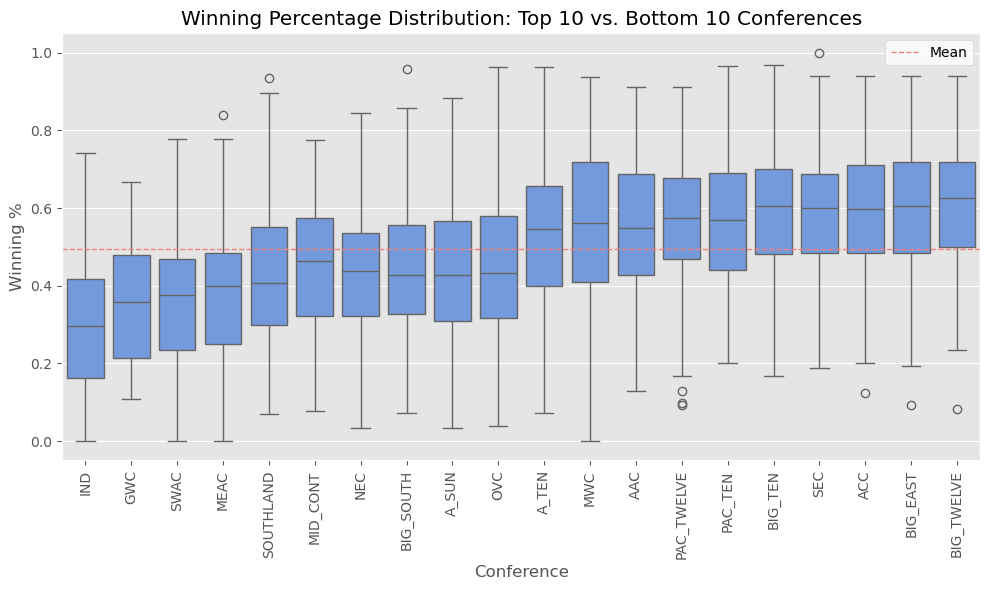

In [534]:
# Compute average winning percentage by conference
conf_means = (
    regular_season_stats.groupby('ConfAbbrev')['WinningPercentage']
    .mean()
    .sort_values()
)

# get top and bottom n conferences
n = 10
top_n = conf_means.tail(n)
bottom_n = conf_means.head(n)

# Combine for plotting
selected_confs = pd.concat([bottom_n, top_n])
conf_order = selected_confs.index

# Create boxplot
fig, ax = plt.subplots(figsize=(10, 6))
sns.boxplot(
    data=regular_season_stats[regular_season_stats['ConfAbbrev'].isin(conf_order)],
    x='ConfAbbrev',
    y='WinningPercentage',
    order=conf_order,
    color='cornflowerblue',
    ax=ax
)

ax.set_title(f"Winning Percentage Distribution: Top {n} vs. Bottom {n} Conferences")
ax.set_xlabel("Conference")
ax.set_ylabel("Winning %")
ax.tick_params(axis='x', rotation=90)


# Add overall mean line
overall_mean = regular_season_stats['WinningPercentage'].mean()
ax.axhline(overall_mean, linestyle='--', color='lightcoral', linewidth=1, label='Mean')

legend = ax.legend()
legend.get_frame().set_facecolor('white')

plt.tight_layout()
plt.show()

The boxplot above illustrates the distribution of winning percentages for teams in the top and bottom conferences (based on historical average winning percentage). 

1. **Top Conferences**:
    - The conferences with the highest average winning percentages are the `Big Ten`, `SEC`, `ACC`, `Big East`, and `Big Twelve`.
    - These conferences exhibit a higher median winning percentage, indicating a generally stronger performance across their teams.
    - The interquartile range (IQR) is relatively narrow, suggesting that the teams within these conferences have more consistent performance levels.

2. **Bottom Conferences**:
    - The conferences with the lowest average winning percentages are the `Independent (IND)`, `Great West Conference (GWC)`, `SWAC`, `MEAC`, and `Southland Conference`.
    - These conferences show a lower median winning percentage, reflecting weaker overall team performance.
    - There is a higher degree of variability in team performance within these conferences.

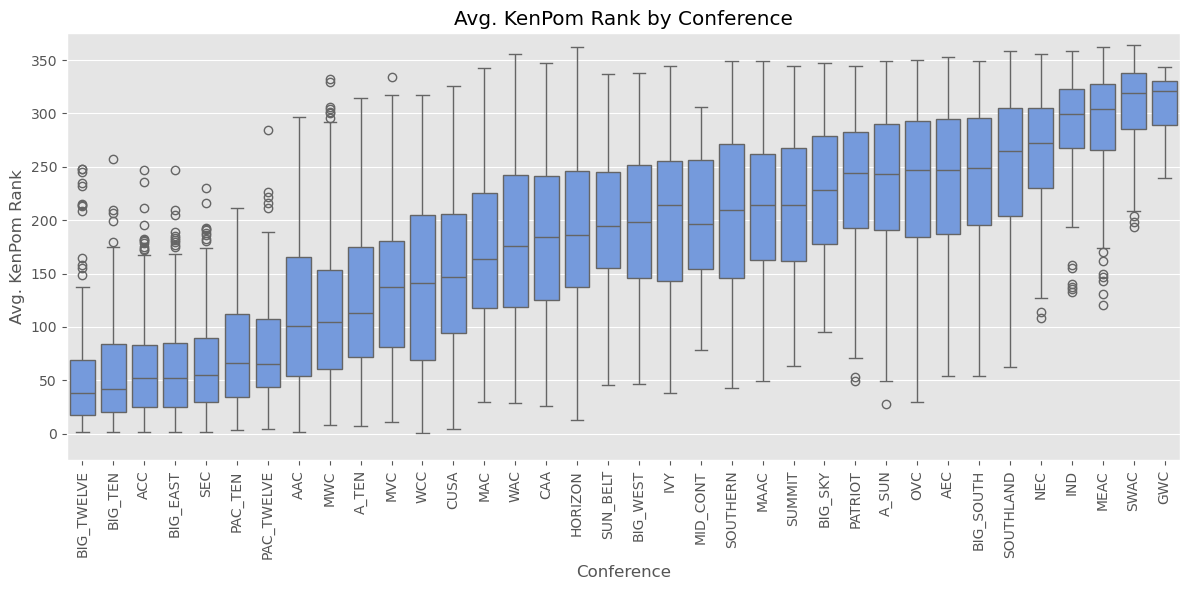

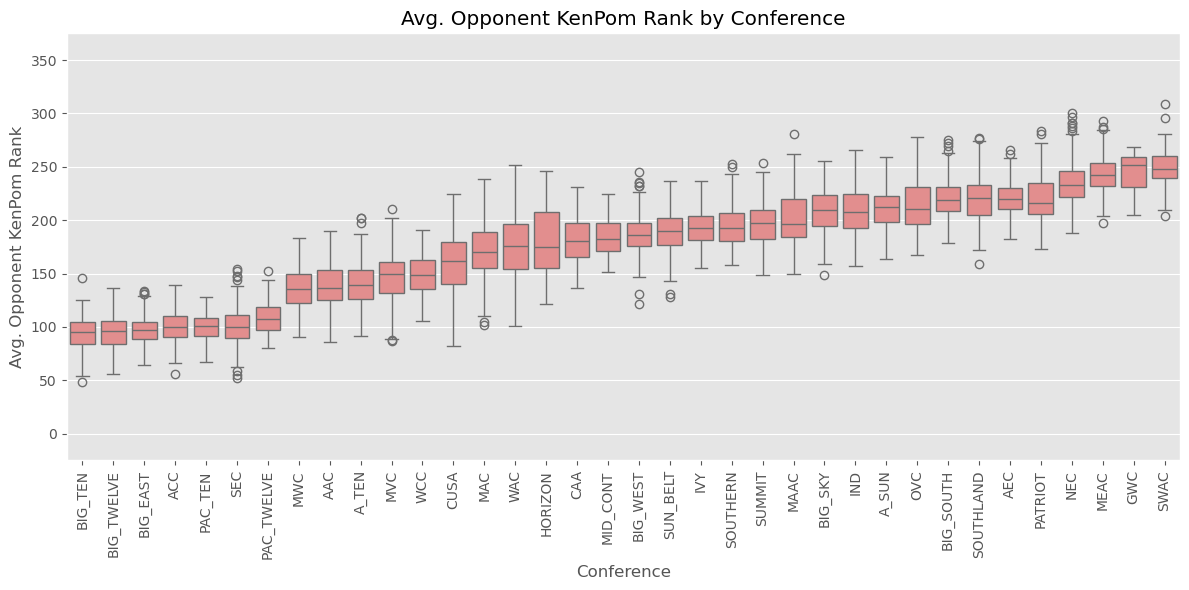

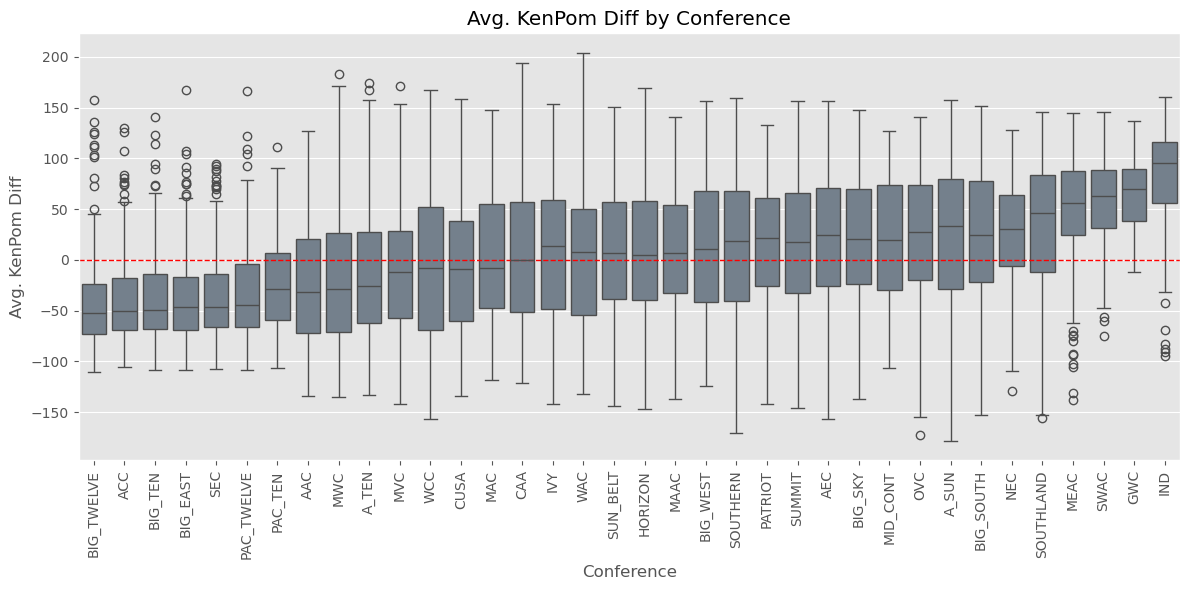

In [535]:
##############################################################################
# Plot 1: Avg. OppKenPomRank by Conference
##############################################################################

# Order by avg KenPomRank
conf_kenpom_avg = (
    regular_season_stats.groupby('ConfAbbrev')['KenPomRank_PerGame']
    .mean()
    .sort_values()
)

# Plot KenPomRank by conference
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=regular_season_stats,
    x='ConfAbbrev',
    y='KenPomRank_PerGame',
    order=conf_kenpom_avg.index,
    color='cornflowerblue',
    ax=ax
)

ax.set_title('Avg. KenPom Rank by Conference')
ax.set_xlabel('Conference')
ax.set_ylabel('Avg. KenPom Rank')
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(-25, 375)

plt.tight_layout()
plt.show()

##############################################################################
# Plot 2: Avg. OppKenPomRank by Conference
##############################################################################

# Order by avg OppKenPomRank
conf_Oppkenpom_avg = (
    regular_season_stats.groupby('ConfAbbrev')['OppKenPomRank_PerGame']
    .mean()
    .sort_values()
)

# Plot OppKenPomRank by conference
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=regular_season_stats,
    x='ConfAbbrev',
    y='OppKenPomRank_PerGame',
    order=conf_Oppkenpom_avg.index,
    color='lightcoral',
    ax=ax
)

ax.set_title('Avg. Opponent KenPom Rank by Conference')
ax.set_xlabel('Conference')
ax.set_ylabel('Avg. Opponent KenPom Rank')
ax.tick_params(axis='x', rotation=90)
ax.set_ylim(-25, 375)

plt.tight_layout()
plt.show()

# Order by avg KenPomRank
conf_kenpom_avg_df = (
    regular_season_stats.groupby('ConfAbbrev')['KenPomDiff_PerGame']
    .mean()
    .sort_values()
)

##############################################################################
# Plot 3: Avg. KenPom Diff by Conference
##############################################################################

# Order by avg KenPomRank
conf_kenpom_avg_diff = (
    regular_season_stats.groupby('ConfAbbrev')['KenPomDiff_PerGame']
    .mean()
    .sort_values()
)

# Plot KenPomRank by conference
fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    data=regular_season_stats,
    x='ConfAbbrev',
    y='KenPomDiff_PerGame',
    order=conf_kenpom_avg_diff.index,
    color='slategray',
    ax=ax
)

ax.axhline(0, linestyle='--', color='red', linewidth=1)
ax.set_title('Avg. KenPom Diff by Conference')
ax.set_xlabel('Conference')
ax.set_ylabel('Avg. KenPom Diff')
ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

***
#### <a id='toc1_9_7_1_'></a>[Inter-Conference Disparities](#toc0_)

We examine conference-level team quality and opponent strength using KenPom-based metrics from 2003–2025. These three views—team KenPom rank, opponent KenPom rank, and the differential between the two—offer a multi-faceted understanding of competition level, parity, and strength of schedule dynamics across Division I conferences.

**1) Team KenPom Rank by Conference**

The first plot visualizes the average `KenPomRank_PerGame` across conferences, where lower values indicate stronger teams.

- Power conferences like the `BIG_TWELVE`, `BIG_TEN`, `SEC`, `ACC`, and `BIG_EAST` consistently rank at the top, showing not only lower (better) average KenPom ranks but also tighter interquartile spreads, suggesting high parity and a deep pool of competitive teams.
- In contrast, mid-major and smaller conferences (e.g., `WCC`, `MVC`, `OVC`) show wider distributions. This reflects the presence of elite outliers like `Gonzaga`, `Drake`, or `Belmont`, who dominate otherwise weaker leagues.
- On the far end, conferences like the `SWAC`, `MEAC`, `GWC`, and `IND` contain the lowest-ranked teams on average, with minimal variance, indicating consistently weaker programs.

**2) Opponent KenPom Rank by Conference**

The second plot evaluates `OppKenPomRank_PerGame`, a proxy for the average quality of opponents faced in the regular season.

- The overall ordering by conference is similar to team KenPom rank: top-tier leagues face better opponents, and lower-tier conferences face weaker ones.
- However, a key observation is that the spread of opponent strength is significantly tighter than team strength across all conferences.
  - While individual team quality varies widely, the quality of opponents within a conference is much more homogeneous.
  - This likely reflects how conference schedules drive much of a team's season. Once in-conference play begins, teams largely face the same pool of opponents, especially in smaller conferences with fewer members.
  - Even dominant mid-majors like `Gonzaga` regularly face lower-ranked opponents, which limits the variance in `OppKenPomRank_PerGame` for conferences like the `WCC`.

**3) KenPom Differential by Conference (Team - Opponent)**

Lastly, we examine `KenPomDiff_PerGame`, the average difference between a team’s own KenPom rank and that of its opponents.

- Power conferences like the `BIG_TWELVE`, `BIG_TEN`, and `SEC` have negative average differentials, meaning their teams are generally playing tougher opponents—expected in leagues with high parity.
- Conversely, conferences like the `SWAC`, `MEAC`, and `IND` show large positive differentials, indicating that even the better teams in those leagues are playing weaker competition.
- Mid-majors like the `WCC` and `MVC` show wide spreads, again highlighting dominant teams (e.g., `Gonzaga`) that outclass their league peers in rating, producing high KenPomDiff_PerGame outliers.

#### <a id='toc1_9_7_2_'></a>[Key Takeaways](#toc0_)

- Power conferences: Low KenPom ranks, strong opponents, and high parity.
- Mid-majors: Mixed KenPom strength, but wide spreads due to a few elite programs.
- Low-majors: Weak average team and opponent ranks, with limited internal variability.
- Opponent KenPom spreads are much narrower, reinforcing the structural constraints of conference schedules.

The plots and notes above contextualize team strength within the structure of conference play and reveals how scheduling ecosystems shape the distribution of quality across Division I. Below we'll look more into the divide between  `"Power Conferences"` and `"Non-Power Conferences"`.
***

#### <a id='toc1_9_7_3_'></a>[Power vs. Non-Power Conferences](#toc0_)

While team-level metrics provide critical insights, conference-level structure remains foundational to understanding trends in Division I men's basketball. Conferences shape scheduling, influence strength of competition, and play a central role in NCAA Tournament selection. As such, differentiating between **Power** and **Non-Power** conferences allows for a more meaningful lens on performance, parity, and program expectations.

Although conference composition evolves slightly over time, a core group of high-major leagues has remained dominant. These so-called **Power Conferences** — namely the `Big_Ten`, `Big_12`, `SEC`, `ACC`, `Big_East`, `Pac_Ten`, and `Pac_Twelve` — consistently demonstrate stronger profiles in average team quality and the strength of their opponents. These conferences not only field more elite programs, but also exhibit tighter, more centralized distributions, indicating a high baseline of performance across their conference members.

Rather than treating each conference separately, let's simplify this into `Power` and `Non-Power` conferences. This allows us to maintain analytical clarity while preserving the competitive distinction.

Later in our analysis, we validate this delineation using NCAA tournament bid data. The same seven conferences that separate themselves in KenPom-based metrics also consistently dominate at-large selections (i.e., send more teams to the tournament than their `Non-Power` counterparts).

In [536]:
power_conferences = ['BIG_TEN', 'BIG_TWELVE', 'SEC', 'ACC', 'BIG_EAST', 'PAC_TEN', 'PAC_TWELVE']

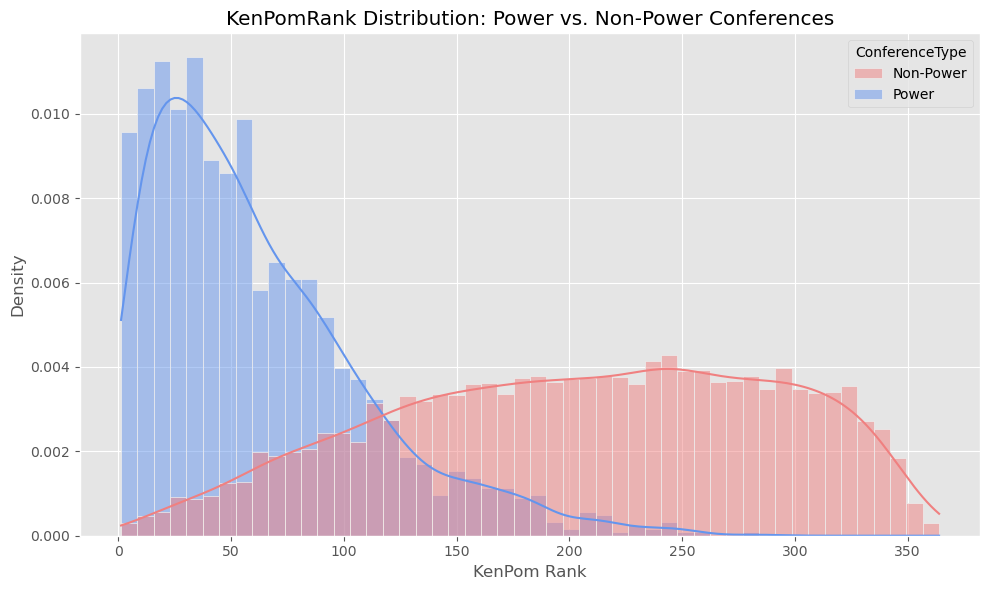

In [537]:
# Create column indicating conference type
regular_season_stats['ConferenceType'] = regular_season_stats['ConfAbbrev'].apply(
    lambda x: 'Power' if x in power_conferences else 'Non-Power'
)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(
    data=regular_season_stats,
    x='KenPomRank_PerGame',
    hue='ConferenceType',
    palette={'Power': 'cornflowerblue', 'Non-Power': 'lightcoral'},
    bins=50,
    kde=True,
    ax=ax,
    stat='density',
    common_norm=False
)

# Labels and title
ax.set_title("KenPomRank Distribution: Power vs. Non-Power Conferences")
ax.set_xlabel("KenPom Rank")
ax.set_ylabel("Density")

plt.tight_layout()
plt.show()

#### <a id='toc1_9_7_4_'></a>[KenPom Rankings: Power vs. Non-Power Conferences](#toc0_)

To compare competitive quality across these groups, we examine KenPom rankings, which combine offensive and defensive efficiency into a pace-adjusted measure of team strength.

- Power conferences exhibit a strong left-skewed distribution, with most teams ranked between 10 and 100. These teams consistently operate in the top tiers of the national basketball landscape.
- Non-Power conferences show a much flatter and wider distribution, with the majority of teams ranked between 150 and 300.
- Spread & Variability:
  - Power conference distributions are more concentrated with less variance — reflecting consistent competition and fewer weak links.
  - Non-Power conference distributions show much wider variance, capturing both strong mid-majors like VCU and San Diego State, as well as consistently low-ranked programs from conferences such as the SWAC and MEAC.

This comparative view underscores how conference affiliation fundamentally shapes a team’s environment — from average opponent strength to overall program quality. It also justifies the use of `PowerConference` as a meaningful feature in downstream analysis and modeling.

***
## <a id='toc1_10_'></a>[Advanced Metrics](#toc0_)

- ELO
***

In [539]:
regular_season_stats

,Season,TeamID,TeamName,ConfAbbrev,Description,TotalGames,TotalWins,TotalLosses,WinningPercentage,Score_PerGame,OppScore_PerGame,NumOT_PerGame,FGM_PerGame,FGA_PerGame,FGM3_PerGame,FGA3_PerGame,FTM_PerGame,FTA_PerGame,OR_PerGame,DR_PerGame,Ast_PerGame,TO_PerGame,Stl_PerGame,Blk_PerGame,PF_PerGame,OppFGM_PerGame,OppFGA_PerGame,OppFGM3_PerGame,OppFGA3_PerGame,OppFTM_PerGame,OppFTA_PerGame,OppOR_PerGame,OppDR_PerGame,OppAst_PerGame,OppTO_PerGame,OppStl_PerGame,OppBlk_PerGame,OppPF_PerGame,Win_PerGame,FG_Percentage_PerGame,FG3_Percentage_PerGame,FT_Percentage_PerGame,Ast_TO_Ratio_PerGame,OppFG_Percentage_PerGame,OppFG3_Percentage_PerGame,OppFT_Percentage_PerGame,OppAst_TO_Ratio_PerGame,Poss_PerGame,OppPoss_PerGame,OffEff_PerGame,DefEff_PerGame,OppOffEff_PerGame,OppDefEff_PerGame,Score_Diff_PerGame,FGM_Diff_PerGame,FGA_Diff_PerGame,FGM3_Diff_PerGame,FGA3_Diff_PerGame,FTM_Diff_PerGame,FTA_Diff_PerGame,OR_Diff_PerGame,DR_Diff_PerGame,Ast_Diff_PerGame,TO_Diff_PerGame,Stl_Diff_PerGame,Blk_Diff_PerGame,PF_Diff_PerGame,Poss_Diff_PerGame,OffEff_Diff_PerGame,DefEff_Diff_PerGame,Score_Diff_Pct_PerGame,FGM_Diff_Pct_PerGame,FGA_Diff_Pct_PerGame,FGM3_Diff_Pct_PerGame,FGA3_Diff_Pct_PerGame,FTM_Diff_Pct_PerGame,FTA_Diff_Pct_PerGame,OR_Diff_Pct_PerGame,DR_Diff_Pct_PerGame,Ast_Diff_Pct_PerGame,TO_Diff_Pct_PerGame,Stl_Diff_Pct_PerGame,Blk_Diff_Pct_PerGame,PF_Diff_Pct_PerGame,Poss_Diff_Pct_PerGame,OffEff_Diff_Pct_PerGame,DefEff_Diff_Pct_PerGame,Score_Diff_Opp_PerGame,FGM_Diff_Opp_PerGame,FGA_Diff_Opp_PerGame,FGM3_Diff_Opp_PerGame,FGA3_Diff_Opp_PerGame,FTM_Diff_Opp_PerGame,FTA_Diff_Opp_PerGame,OR_Diff_Opp_PerGame,DR_Diff_Opp_PerGame,Ast_Diff_Opp_PerGame,TO_Diff_Opp_PerGame,Stl_Diff_Opp_PerGame,Blk_Diff_Opp_PerGame,PF_Diff_Opp_PerGame,Poss_Diff_Opp_PerGame,OffEff_Diff_Opp_PerGame,DefEff_Diff_Opp_PerGame,Score_Diff_Pct_Opp_PerGame,FGM_Diff_Pct_Opp_PerGame,FGA_Diff_Pct_Opp_PerGame,FGM3_Diff_Pct_Opp_PerGame,FGA3_Diff_Pct_Opp_PerGame,FTM_Diff_Pct_Opp_PerGame,FTA_Diff_Pct_Opp_PerGame,OR_Diff_Pct_Opp_PerGame,DR_Diff_Pct_Opp_PerGame,Ast_Diff_Pct_Opp_PerGame,TO_Diff_Pct_Opp_PerGame,Stl_Diff_Pct_Opp_PerGame,Blk_Diff_Pct_Opp_PerGame,PF_Diff_Pct_Opp_PerGame,Poss_Diff_Pct_Opp_PerGame,OffEff_Diff_Pct_Opp_PerGame,DefEff_Diff_Pct_Opp_PerGame,KenPomRank_PerGame,OppKenPomRank_PerGame,KenPomDiff_PerGame,OppKenPomDiff_PerGame,Score_PerWin,OppScore_PerWin,NumOT_PerWin,FGM_PerWin,FGA_PerWin,FGM3_PerWin,FGA3_PerWin,FTM_PerWin,FTA_PerWin,OR_PerWin,DR_PerWin,Ast_PerWin,TO_PerWin,Stl_PerWin,Blk_PerWin,PF_PerWin,OppFGM_PerWin,OppFGA_PerWin,OppFGM3_PerWin,OppFGA3_PerWin,OppFTM_PerWin,OppFTA_PerWin,OppOR_PerWin,OppDR_PerWin,OppAst_PerWin,OppTO_PerWin,OppStl_PerWin,OppBlk_PerWin,OppPF_PerWin,Win_PerWin,FG_Percentage_PerWin,FG3_Percentage_PerWin,FT_Percentage_PerWin,Ast_TO_Ratio_PerWin,OppFG_Percentage_PerWin,OppFG3_Percentage_PerWin,OppFT_Percentage_PerWin,OppAst_TO_Ratio_PerWin,Poss_PerWin,OppPoss_PerWin,OffEff_PerWin,DefEff_PerWin,OppOffEff_PerWin,OppDefEff_PerWin,Score_Diff_PerWin,FGM_Diff_PerWin,FGA_Diff_PerWin,FGM3_Diff_PerWin,FGA3_Diff_PerWin,FTM_Diff_PerWin,FTA_Diff_PerWin,OR_Diff_PerWin,DR_Diff_PerWin,Ast_Diff_PerWin,TO_Diff_PerWin,Stl_Diff_PerWin,Blk_Diff_PerWin,PF_Diff_PerWin,Poss_Diff_PerWin,OffEff_Diff_PerWin,DefEff_Diff_PerWin,Score_Diff_Pct_PerWin,FGM_Diff_Pct_PerWin,FGA_Diff_Pct_PerWin,FGM3_Diff_Pct_PerWin,FGA3_Diff_Pct_PerWin,FTM_Diff_Pct_PerWin,FTA_Diff_Pct_PerWin,OR_Diff_Pct_PerWin,DR_Diff_Pct_PerWin,Ast_Diff_Pct_PerWin,TO_Diff_Pct_PerWin,Stl_Diff_Pct_PerWin,Blk_Diff_Pct_PerWin,PF_Diff_Pct_PerWin,Poss_Diff_Pct_PerWin,OffEff_Diff_Pct_PerWin,DefEff_Diff_Pct_PerWin,Score_Diff_Opp_PerWin,FGM_Diff_Opp_PerWin,FGA_Diff_Opp_PerWin,FGM3_Diff_Opp_PerWin,FGA3_Diff_Opp_PerWin,FTM_Diff_Opp_PerWin,FTA_Diff_Opp_PerWin,OR_Diff_Opp_PerWin,DR_Diff_Opp_PerWin,Ast_Diff_Opp_PerWin,TO_Diff_Opp_PerWin,Stl_Diff_Opp_PerWin,Blk_Diff_Opp_PerWin,PF_Diff_Opp_PerWin,Poss_Diff_Opp_PerWin,OffEff_Diff_Opp_PerWin,DefEff_Diff_Opp_PerWin,Score_Diff_Pct_Opp_PerWin,FGM_Diff_Pct_Opp_PerWin,FGA_Diff_Pc

In [ ]:
# Checkpoint - Save df to csv
regular_season_stats.to_csv('./Data/Live/RegularSeasonStats.csv', index=False)